# Generating Offenders

In [1]:
import random
from random import randrange
import sys
import math
import randomtimestamp
from randomtimestamp import random_time
import datetime
from datetime import timedelta
import geopy
from geopy import distance
import folium
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
#Generating a map using the sydney coordinates with a latitude and longitude popup
sydney=(-33.8168,151.0304)
sydmap=folium.Map(sydney,zoom_start=11)
sydmap.add_child(folium.LatLngPopup())

In [3]:
#These are the latutude and longitude ranges within which we will generate offenders and detectors
lat_range=(-33.9674,-33.5403)
long_range=(151.2402,150.6417)

In [4]:
import openrouteservice
#setup openroute service client using api-key
client=openrouteservice.Client(key='5b3ce3597851110001cf6248453352de6c684fa79bc48fa1ab654e53')

In [5]:
api_key='6f6a2741dcmsh50e296b77366b59p1ba757jsn1d01354328e4'
url = "https://route-and-directions.p.rapidapi.com/v1/routing"
host = "route-and-directions.p.rapidapi.com"
headers = {"X-RapidAPI-Key": api_key, "X-RapidAPI-Host": host}

In [6]:
coordinates_for_liquor=[]

#The list of coordinates around which search is done to find the liquor stores
coordinates_for_poi1=[[-33.7989,150.9984],[-33.8014,151.1979],[-33.9343,151.1578],[-33.8999,151.1803],[-33.9444,150.8782],[-33.9163,150.9298],[-33.7261,150.7337],[-33.9175,150.9042],[-33.7312,150.7321],[-33.7677,150.7854],[-33.8026,151.1989],[-33.7125,150.9714],[-33.8999,151.1382],[-33.9139,151.2317],[-33.7298,150.8354],[-33.8664,151.1971],[-33.9360,151.1586],[-33.8775,150.9058],[-33.7523,150.8280],[-33.8576,151.0973]]

#Since our point of interest(poi) is a liquor store, the api key can search around a point for as far as 2km.
#Thus inorder to find these stores, multiple points are selected around which a 2km search is performed to find maximum number of stores.
#After a lot of experimentation, the above coordinates are selected that find maximum number of liquor stores.

In [7]:
import geopy
from geopy.geocoders import Nominatim
#This is used inorder to find the address given a location (coordinates)

# initialize Nominatim API
geolocator = Nominatim(user_agent="geoapi")

#Function to find the shop name
def shop_name(lat_long):
    # Latitude & Longitude input
    Latitude = str(lat_long[0])
    Longitude =str(lat_long[1])

    location = geolocator.reverse(Latitude+","+Longitude)
    #Given the coordinates, the location of the place is found

    address = location.raw['address']
    #This location can be converted to a dictionary to access each element of it if we want.

    return location

In [8]:
#In case any exceptions happen while finding poi like timeout errors etc
def find_poi(geojson):
    #execute the code within try block to find poi
    try:
        pois = client.places(request='pois',
                          geojson=geojson,
                          #buffer searches (in meters) around specified point
                          buffer=2000,
                          #code for bar, alcohol,nightclubs 
                          filter_category_ids=[303,422,561])
        return pois
    #If any exception occurs, except block is executed
    except:
        #Find the poi since exception occured
        find_poi(geojson)

In [9]:
#for i in coordinates_to_find_liq:
for j in coordinates_for_poi1:
            #coordinates which is stored as a dictionary called geojson to find the poi
            geojson = {"type": "point", "coordinates": [j[1],j[0]]}
            coordinates = [j[0],j[1]]
            
            pois=None
            #Since we are using try except, there is a chance that sometimes poi returned is 'None'.
            #Thus we will keep calling the find_poi function until we find poi (i.e until poi is NOT None)
            while pois==None:
            # places of interest
                pois=find_poi(geojson)

            
            print("Finding Liquor stores............")
            # add markers to map
            #Iterating through each liquor store found inorder to mark it to the map with the popup
            for poi in pois['features']:
                #Append the coordinates of the liquor store to the list
                coordinates_for_liquor.append(list(reversed(poi['geometry']['coordinates'])))
                
                #Inorder to find the address of each store to add as popup, call shop_name function defined above
                pop=shop_name(list(reversed(poi['geometry']['coordinates'])))
                
                #Add a circlemarker to the location of the store
                folium.CircleMarker(location=list(reversed(poi['geometry']['coordinates'])),
                              color='crimson',fill_color=True,popup=pop).add_to(sydmap)

# display map
sydmap

Finding Liquor stores............
Finding Liquor stores............
Finding Liquor stores............
Finding Liquor stores............
Finding Liquor stores............
Finding Liquor stores............
Finding Liquor stores............
Finding Liquor stores............
Finding Liquor stores............
Finding Liquor stores............
Finding Liquor stores............
Finding Liquor stores............
Finding Liquor stores............
Finding Liquor stores............
Finding Liquor stores............
Finding Liquor stores............
Finding Liquor stores............
Finding Liquor stores............
Finding Liquor stores............
Finding Liquor stores............


In [10]:
#Number of liquor stores
len(coordinates_for_liquor)

278

In [11]:
#Input percent of offenders starting from the liquor store
liq_offenders=int(input("Enter the number of offenders that begin from liquor stores:"))

Enter the number of offenders that begin from liquor stores:20


In [12]:
#function to generate random start and end points
def generate_start_end():
    
    start_lat_long=(random.uniform(*lat_range),random.uniform(*long_range))
    end_lat_long=(random.uniform(*lat_range),random.uniform(*long_range))

    return(start_lat_long,end_lat_long)

In [13]:
#Funtion to choose a start point beginning from liquor store and randomly selected end point
def choose_start():
    #randomly choose a start point for the offender that must begin from the liquor store
    start_lat_long=random.choice(coordinates_for_liquor)

    #randomly select an end point
    end_lat_long=(random.uniform(*lat_range),random.uniform(*long_range))

    return start_lat_long,end_lat_long

In [14]:
#function to generate a random departure time between a given interval of time
def time_within_interval(start, end):
    t=str(timedelta(seconds=randrange(timedelta(hours=start).total_seconds(),
                                       timedelta(hours=end).total_seconds())))
    if ',' in t:
        t=t[7:]
        
    #Now splitting this at ':' to get hr,min,sec seperately
    t=[int(i) for i in t.split(':')]
    
    #Use this to create a time object
    t=datetime.time(hour=t[0],minute=t[1],second=t[2])
    
    #creating the text required for the popup (html markups are <h4> <b> which help to bold the text)
    time_txt = "<h4> <b>Departure time :&nbsp" + "<strong>"+str(t)+"</strong>" +"</h4></b>"
    
    return time_txt,t
    #This time is in hrs:min:sec format

In [15]:
#Since we are going to set 100 offenders on the map, we will represent the markers with different colors
#i.e. 1 color for each offender
colors = [
    'red',
    'blue',
    'gray',
    'darkred',
    'lightred',
    'orange',
    'beige',
    'green',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'purple',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black'
]
#These are the colors avaialble for markers

In [16]:
#This list contains the route coordinates between all offenders
route_coordinates_with_time=[]

#This list stores the start and end of all the 100 coordinates
offenders_coordinates=[]

#Possible Coordinates for test points
points_off=[]

In [17]:
def set_probability(i,prob_list):
    if i<prob_list[0]:
        time_txt,rand_time=time_within_interval(0,2)
    elif i<sum(prob_list[:2]):
        time_txt,rand_time=time_within_interval(2,4)
    elif i<sum(prob_list[:3]):
        time_txt,rand_time=time_within_interval(4,6)
    elif i<sum(prob_list[:4]):
        time_txt,rand_time=time_within_interval(6,8)
    elif i<sum(prob_list[:5]):
        time_txt,rand_time=time_within_interval(8,10)
    elif i<sum(prob_list[:6]):
        time_txt,rand_time=time_within_interval(10,12)
    elif i<sum(prob_list[:7]):
        time_txt,rand_time=time_within_interval(12,14)
    elif i<sum(prob_list[:8]):
        time_txt,rand_time=time_within_interval(14,16)
    elif i<sum(prob_list[:9]):
        time_txt,rand_time=time_within_interval(16,18)
    elif i<sum(prob_list[:10]):
        time_txt,rand_time=time_within_interval(18,20)
    elif i<sum(prob_list[:11]):
        time_txt,rand_time=time_within_interval(20,22)
    else:
        time_txt,rand_time=time_within_interval(22,24)
    return time_txt,rand_time

In [18]:
def get_directions_response(lat1, long1, lat2, long2, mode='drive'):
    try:
        querystring = {"waypoints":f"{str(lat1)},{str(long1)}|{str(lat2)},{str(long2)}","mode":mode}
        response = requests.request("GET", url, headers=headers, params=querystring)
        return response.json(),lat1,long1,lat2,long2
    except:
        #generate new points that would have a route between them
        print('Trying new points since route not found between old points')
        start_lat_long,end_lat_long=generate_start_end()
        lat1,long1,lat2,long2=start_lat_long[0],start_lat_long[1],end_lat_long[0],end_lat_long[1]
        get_directions_response(lat1, long1, lat2, long2)

In [19]:
def generate_offenders(num,f_name,off_numb): 
      #num: number of offenders to be generated
      #f_name: which function needs to be applied (if we need to start from liquor or randomly)
    
      #Creating a probability list to set the probability
      prob_list=[round((50/257)*num,0),round((40/257)*num,0),round((16/257)*num,0),round((10/257)*num,0),round((5/257)*num,0),
          round((5/257)*num,0),round((5/257)*num,0),round((5/257)*num,0),round((13/257)*num,0),round((28/257)*num,0),
          round((38/257)*num,0),round((42/257)*num,0)]
      
      #increasing the probability of offenders whose distance lies within 15-18km 
      prob_dist=int((random.randint(50,70)/100)*num)
      
      for i in range(num):
        res={}
        
        print("Finding route of offender "+str(i+1)+"........................")
        
        #generate random start and end points and find routes between them
        #If the route returned is None, continue this process until a route is found.
        while ('features' not in res) or ('features' in res and i<prob_dist):
              start_lat_long,end_lat_long=f_name()
              lat1,long1,lat2,long2=start_lat_long[0],start_lat_long[1],end_lat_long[0],end_lat_long[1]
              res,lat1,long1,lat2,long2=get_directions_response(lat1, long1, lat2, long2)
              if 'features' in res and i<prob_dist:
                  dist_off=round(res['features'][0]['properties']['distance']/1000,1)
                  if dist_off<5 or dist_off>18:
                    print('Distance requirements not met,trying again to create offender'+str(i+1)+'............................')
                    continue
                  else:
                    break
                       
        
        #append to the list of coordinates of the offenders
        offenders_coordinates.append([(lat1,long1),(lat2,long2)])
        
        #As our purpose is to draw the route between the given points, we could use the routes’s geometry attribute.
        route=res['features'][0]['geometry']['coordinates'][0]
        #res['routes'][0]['geometry'] contains the coordinates of the route between the two coordinates
        #Now converting this to a line to plot it on the map using decode_polyline
        points = [(j[1], j[0]) for j in route]

        #To add the popup
        #The tags like <h4> <b> which is used to bolden the text of the popup
        #res['routes'][0]['summary']['distance'] shows the distance which is found by the api. It is divided by 1000 to get in km.
        #res['routes'][0]['summary']['duration'] shows the time to reach the destination in seconds. Divide by 60 to get in minutes
        distance_txt = "<h4> <b>Distance :&nbsp" + "<strong>"+str(round(res['features'][0]['properties']['distance']/1000,1))+" Km </strong>" +"</h4></b>"
        duration_txt = "<h4> <b>Duration :&nbsp" + "<strong>"+str(round(res['features'][0]['properties']['time']/60,1))+" Mins. </strong>" +"</h4></b>"
        #Generating random time and increasing probability 
        
        time_txt,rand_time=set_probability(i,prob_list)

        #Adding this random time too to the popup.
        pop="<h4> <b>Offender"+str(off_numb+i+1)+"</h4></b>"+distance_txt+duration_txt+time_txt

        #Add the route of this offender to the list 'route coordinates'
        route_coordinates_with_time.append([points,rand_time])
        
        for j in points:
            points_off.append(j)
        
        #Add these generated points and popup to the map using the code below
        #colors[i%18] indicates using same colors for the same offenders
        folium.Marker((lat1,long1),icon=folium.Icon(color=colors[i%18]),popup=pop).add_to(sydmap)
        folium.Marker((lat2,long2),icon=folium.Icon(color=colors[i%18]),popup=pop).add_to(sydmap)
        #Add this popup to the map
        folium.PolyLine(points, weight=5, opacity=1).add_child(folium.Popup(pop,max_width=100)).add_to(sydmap)

In [20]:
#Generating offenders that begin from the liquor store 
print('Generating '+str(liq_offenders)+' offenders starting from liquor stores:')
generate_offenders(liq_offenders,choose_start,0)

Generating 20 offenders starting from liquor stores:
Finding route of offender 1........................
Distance requirements not met,trying again to create offender1............................
Finding route of offender 2........................
Distance requirements not met,trying again to create offender2............................
Distance requirements not met,trying again to create offender2............................
Distance requirements not met,trying again to create offender2............................
Distance requirements not met,trying again to create offender2............................
Distance requirements not met,trying again to create offender2............................
Distance requirements not met,trying again to create offender2............................
Distance requirements not met,trying again to create offender2............................
Distance requirements not met,trying again to create offender2............................
Distance requirements no

Finding route of offender 12........................
Finding route of offender 13........................
Finding route of offender 14........................
Finding route of offender 15........................
Finding route of offender 16........................
Finding route of offender 17........................
Finding route of offender 18........................
Finding route of offender 19........................
Finding route of offender 20........................


In [21]:
#Shows starting points of these offenders from liquor store
sydmap

In [22]:
#Generating the remaining offenders from random start points
print('Generating the remaining offenders from random start points:')
generate_offenders(50-(liq_offenders),generate_start_end,liq_offenders)

Generating the remaining offenders from random start points:
Finding route of offender 1........................
Distance requirements not met,trying again to create offender1............................
Distance requirements not met,trying again to create offender1............................
Finding route of offender 2........................
Distance requirements not met,trying again to create offender2............................
Distance requirements not met,trying again to create offender2............................
Distance requirements not met,trying again to create offender2............................
Distance requirements not met,trying again to create offender2............................
Distance requirements not met,trying again to create offender2............................
Distance requirements not met,trying again to create offender2............................
Distance requirements not met,trying again to create offender2............................
Distance require

Distance requirements not met,trying again to create offender13............................
Distance requirements not met,trying again to create offender13............................
Distance requirements not met,trying again to create offender13............................
Distance requirements not met,trying again to create offender13............................
Distance requirements not met,trying again to create offender13............................
Finding route of offender 14........................
Distance requirements not met,trying again to create offender14............................
Finding route of offender 15........................
Distance requirements not met,trying again to create offender15............................
Distance requirements not met,trying again to create offender15............................
Distance requirements not met,trying again to create offender15............................
Finding route of offender 16........................
Distance requ

In [23]:
#Showing all the offenders
sydmap

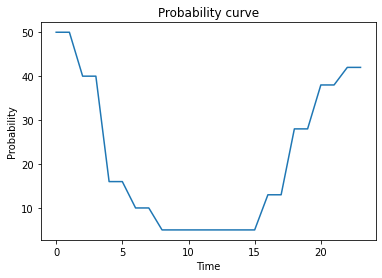

In [28]:
#Creating the probability curve
time=list(range(0,24))
time_prob={}
for i in time:
    if i in [0,1]:
        time_prob[i]=50
    elif i in [2,3]:
        time_prob[i]=40
    elif i in [4,5]:
        time_prob[i]=16
    elif i in [6,7]:
        time_prob[i]=10
    elif i in [8,9]:
        time_prob[i]=5
    elif i in [10,11]:
        time_prob[i]=5
    elif i in [12,13]:
        time_prob[i]=5
    elif i in [14,15]:
        time_prob[i]=5
    elif i in [16,17]:
        time_prob[i]=13
    elif i in [18,19]:
        time_prob[i]=28
    elif i in [20,21]:
        time_prob[i]=38
    elif i in [22,23]:
        time_prob[i]=42
        
#Creating the probability curve
#Plotting
data=pd.DataFrame(time_prob.values())
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Probability curve')
plt.show()

# Generating Detectors:

In [24]:
#input the minimum and maximum of time range
#Since we input in format hr:min:sec, we use use a split function that splits the input when a ':' appears.
lower_limit=[int(i) for i in input("Enter lower limit for time range in hr:min:sec format: ").split(':')]
#Thus we will have hr,min,sec seperately which can be then used to convert to datetime format.
lower_limit=datetime.time(hour=lower_limit[0],minute=lower_limit[1],second=lower_limit[2])

#The similar technique is applied below
upper_limit=[int(i) for i in input("Enter upper limit for time range in hr:min:sec format: ").split(':')]
upper_limit=datetime.time(hour=upper_limit[0],minute=upper_limit[1],second=upper_limit[2])

Enter lower limit for time range in hr:min:sec format: 00:30:00
Enter upper limit for time range in hr:min:sec format: 4:00:00


In [25]:
#Input the maximum working hours
max_hours=int(input('Enter the maximum working hours :'))

Enter the maximum working hours :80


In [26]:
#Converting the upper and lower limit to minutes
min_minute=(lower_limit.hour)*60+lower_limit.minute
max_minute=(upper_limit.hour)*60+upper_limit.minute

In [27]:
#Generating a random time range(15 min cycle) between the upper and lower limit
def generate_random_timeRange():
    #random.randrange generate a random range between an upper and lower limit 
    return datetime.timedelta(seconds=(random.randrange(min_minute,max_minute+1,15)*60))

In [28]:
#Input the maximum number of test points allowed in a schedule
detector_count=int(input("Enter the maximum number of test points allowed in a schedule:"))

Enter the maximum number of test points allowed in a schedule:40


In [29]:
#Function to subtract two times
def sub_times(time1,time2):
    #subtract two times
    hour=abs(time1.hour-time2.hour)
    minute=abs(time1.minute-time2.minute)
    time3=datetime.time(hour=hour,minute=minute)
    
    #return this difference as minutes
    return time3

In [30]:
#Function for converting the duration to hours,minutes,seconds
def con_to_hm(time):
    hours = int(time/3600)
    minutes = int((time/60) % 60)
    return(hours,minutes)

In [31]:
def delta_to_time(time):
    time=str(time)
    if ',' in time:
        time=time[7:]
    #Now splitting this at ':' to get hr,min,sec seperately
    time=[int(i) for i in time.split(':')]
    #Use this to create a time object
    time=datetime.time(hour=time[0],minute=time[1],second=time[2])
    return time

In [32]:
#Creating a function to add two times to get the upper and lower time of detector
def add_times(time,rnge):
    #Randomly generating a time range
    #rnge=generate_random_timeRange()
    
    #add two times using timedelta since we can not perform normal add operations on time objects and convert to string.
    time2=str(datetime.timedelta(hours=time.hour,minutes=time.minute,seconds=time.second)+rnge)
    #Now we need to convert it into time object
    
    #convert string into datetime format
    #Sometimes after adding 23:00 with 2, datetime may show 1 day,1 o'clock as time.
    #Since we want time of only one day, we need to remove '1 day,' from it.
    #For this, the code after the ',' of '1 day,' is taken, i.e we only want time which is 1 o'clock.
    if ',' in time2:
        time2=time2[7:]
        
    #Now splitting this at ':' to get hr,min,sec seperately
    time2=[int(i) for i in time2.split(':')]
    #Use this to create a time object
    time2=datetime.time(hour=time2[0],minute=time2[1],second=time2[2])
    
    return time2

In [33]:
#Ensuring the detector is not in an intersection

#Read the dataset
import pandas as pd
intersection_coordinates=pd.read_csv('Intersection coordinates.csv')
#Intersection coordinates.csv is a file that contains nearly 77000 coordinates that are intersections in the entire sydney area.

#Define a function to check whether the given point is an intersection or not.
def check_intersection(lat,long):
    count=0
    val=0
    
    #Iterating through each value of the 'lat' column of the dataset (viz. latutude)
    for i in intersection_coordinates['lat']:
        #if the given latitude and any latitude in the dataset matches, then we need to check its corresponding longitude also.
        if round(i,6)==lat:
            
            #Storing the corresponding longitude value to 'val' and checking if it matches the given longitude value.
            #It returns true if the longitude also matches.
            val=intersection_coordinates['lon'][count]
            if round(val,6)==long:
                
                return True
                #returns true if the detector is at an intersection
                
        count+=1
    return False

In [34]:
#For sorting
def myFunc1(i):
    return i[0]

## Determining traffic of the road:

In [35]:
def find_ll_of_road(june_data):
    #Generating the roads present for 2nd june
    roads_for_june=[]

    #Checking the roads and storing it in roads_for_june list
    for i in june_data['road_name'].unique():
        roads_for_june.append(i)

    #Storing the lat and long of the roads in a dictionary
    lat_long_roads={}

    for j in roads_for_june:
        ll=[]
        for i in range(len(june_data)):
            #Storing all possible lat and long values of the road
            if june_data['road_name'][i]==j and ((june_data['latitude'][i],june_data['longitude'][i]) not in ll):
                ll.append((june_data['latitude'][i],june_data['longitude'][i]))
        lat_long_roads[j]=ll
    
    return lat_long_roads

In [36]:
#Function for finding the closest road incase it is an auxilary road
def find_closest_road(lat_long_roads,lat,long):
    #Checking the location is close to which road:
    #j[0] is key and j[1] is value
    dist=999999
    closer_road=''
    for j in lat_long_roads.items():
        for k in j[1]:
            
            #Checking the distance between the main road and auxilary road to check which main road it is closer to
            calc_dist=distance.distance(k,(lat,long))
            #The one having minimum distance will be closer
            
            if calc_dist<dist:
                
                #Keep finding minimum distance until all roads are checked
                closer_road=j[0]
                dist=calc_dist
                
    #return the closest road
    return closer_road

In [37]:
#Define function to find the total number of vehicles of a road
def num_of_vehicles(june_data,t1,t2,closer_road):
    # If its 15mins=/4, if 30mins=/2 ,if 45 mins=/1.33
    vehicles=0
    for i in range(len(june_data)):
        #Finding the road to calculate the road traffic
        if june_data['road_name'][i]==closer_road:
            
            #If the minutes are zero, then completely include the first hour with the last hour
            if t1.minute==0:
                for k in list(june_data.loc[i][3:27])[t1.hour:t2.hour]:
                    if k>240:
                        vehicles+=240
                    else:
                        vehicles+=k
            
            #If not, perform division depending on the minutes
            else:
                hr=(60/t1.minute)
                if (list(june_data.loc[i][3:27])[t1.hour])/hr>(240/hr):
                    vehicles+=(240/hr)
                else:
                    vehicles+=list(june_data.loc[i][3:27])[t1.hour]/hr
            
                
                #Include the remaining traffic till the upper limit
                for k in list(june_data.loc[i][3:27])[t1.hour+1:t2.hour+1]:
                    if k>240:
                        vehicles+=240
                    else:
                        vehicles+=k
            
            #If upper limit also has minutes, then perform required division
            if t2.minute!=0:
                hr=(60/t2.minute)
                if (list(june_data.loc[i][3:27])[t2.hour])/hr>(240/hr):
                    vehicles+=(240/hr)
                else:
                    vehicles+=(list(june_data.loc[i][3:27])[t2.hour])/hr
                    
                
            break
            
    if vehicles==0:
        rnge=sub_times(t1,t2)
        return int(rnge.hour*240+(((rnge.minute)/15)*60))
    
    #return the vehicle count
    return int(vehicles)

# GENETIC ALGORITHM:

Steps like creating initial population and calculating the fitness is the same, and hence will be used in the PSO section too.

## Defining the Genetic Algorithm

In [38]:
#generate solutions (coordinates of detectors):
def create_initialPopulation(num,lat_long_roads,june_data):
    #This will contain our set of coordinates for the detectors that form the initial population.
    solutions=[]
    
    #Initializing total time to ensure it does not exceed maximum working hours
    tot_time=0.0
    
    for i in range(num): #randomly generate 'num' detectors
        
        #Randomly generate a range
        rnge=generate_random_timeRange()
        
        rnge_conv=delta_to_time(rnge)
        #print('Total time at present:'+str(tot_time))
        #Add it with the total time
        tot_time+=(rnge_conv.hour+(rnge_conv.minute)/60)
        #print('New Total time:...................'+str(tot_time))
        
        if tot_time>max_hours:
            print('Total time:'+str(tot_time-(rnge_conv.hour+(rnge_conv.minute)/60)))
            return solutions
        
        #generate the initial and final time based on the time range
        time=random.randint(0,24-(upper_limit.hour+1))
        time=datetime.time(hour=time,minute=0,second=0)

        time2=add_times(time,rnge)
        
        #generate a random latitude and longitude
        lat_long=random.choice(points_off)
        
        #check whether its at an intersection
        while check_intersection(lat_long[0],lat_long[1])==True:
            lat_long=random.choice(points_off)
            
        lat,long=lat_long[0],lat_long[1]
            
        #Checking the traffic on that road
        #First find the road name
        #road=road_name(lat,long)
        
        #If the detector is not exactly on the street and somewhere near by it or if its on an auxillary road,
        #then find the road nearest to it
        
        closer_road=find_closest_road(lat_long_roads,lat,long)
        
        #Analyzing traffic of the road
        vehicles=num_of_vehicles(june_data,time,time2,closer_road)
        
        solutions.append([(lat,long),[time,time2],vehicles])
        
    print('Total time:'+str(tot_time))
    return solutions

In [39]:
from itertools import chain
#b={'hi':[1,2,3,4],'hello':[2,3,44,5]}
#list(chain.from_iterable(b.values()))

### Fitness function:

In [40]:
#Initializing fitness
fitness=0
#Defining a fitness function

#To store the offender id caught by each detector, create a dictionary
off_id={}

def find_fitness(x,y,time,off_id): #x,y stands for the lat and long of the detector
    
    id_of_offender=0 #to keep track of id of the offender 
    list_of_offender=[] #to keep all the offender id's caught by the detector
    fitness=0 #we need to maximize this (maximum number of offenders caught is the most optimal detector.)
    

    #Iterating through the coordinates of the route for each offenders
    for i in route_coordinates_with_time:
        
        if id_of_offender not in list(chain.from_iterable(off_id.values())):
            for j in i[0]:

                #checking the number of times an offender passes through the detector
                #If any coordinate in the route of an offender matches that of the detector, and is within the time range of the detector,
                #then it means the detector will catch that offender.
                #That means you can increment fitness value for that particular detector.
                if x==j[0] and y==j[1] and time[0]<=i[1] and i[1]<=time[1]: 

                    #Store the offender id if its caught by the detector
                    list_of_offender.append(id_of_offender)
                    fitness+=1 #this should be maximum
                
        id_of_offender+=1
    
    #if the detector catches any offender, then its added to the off_id dictionary along with the coordinates of the detector as the key.

    if list_of_offender!=[]:
        off_id[(x,y)]=list_of_offender
        
    return fitness,off_id

### Genetic Algorithm:

In [41]:
#function to perform genetic algorithm
def ga(solutions,num_iter,alpha,june_data,off_id):
    """"
    solutions is the initial population
    num_iter:number of generations
    off_pop:how many offsprings to be added to form new population
    mut_init and mut_final are the inital and final mutations
    """
    
    #Create a list that stores the best ftiness of each iteration
    plot_data=[]
    
    #stores the best schedule of each iteration
    bestschedule=[]
    
    #-----------------------------------------------------BEGIN ITERATION----------------------------------------------------
    for i in range(num_iter):

        print('ITERATION NUMBER: '+str(i+1)+"---------------------------------------------")
        
        off_id_schedule=[]
        #Iterating through each schedule
        schedule_with_fitness=[] #Stores fitnesses of each schedule
        for s in solutions:
            off_id={}
            tot_fitness=0 #Total fitness of the schedule
            combined_fitness=0 
            soltn_with_fitness=[] #Stores fitnesses of each test point
            
            #Iterating through each test point in the schedule
            for j in s:
                
                #combined_fitness=alpha*x1+x2
                fit,off_id=find_fitness(j[0][0],j[0][1],j[1],off_id)
                combined_fitness=alpha*fit+j[2]
                
                #Append the fitness of the TEST POINT with the TEST POINT
                soltn_with_fitness.append((combined_fitness,j))
                
                #Finding the total fitness
                tot_fitness+=combined_fitness
                
            #Append the offender ids caught during each schedule to the off_id_schedule list
            off_id_schedule.append(off_id) 
                
            #Append the fitness of the SCHEDULE and the schedule to the list
            schedule_with_fitness.append((tot_fitness,soltn_with_fitness))
            
            #Find index of schedule with maximum fitness
            ind=np.argmax(schedule_with_fitness,axis=0)[0]
            off_id=off_id_schedule[ind]
            
        #--------------------------------------------------SORT THE SCHEDULES-------------------------------------------------
            
        print('Sorting......................')
        #Now we have the fitness values of each schedule in the list 'schedule_with_fitness'
        #Sort it.
        schedule_with_fitness.sort(key=myFunc1,reverse=True)
        
        #Store the schedule with maximum fitness
        best=schedule_with_fitness[0]
        #Add this best schedule to 'bestschedule' list
        bestschedule.append(best)
        #Append the fitness of this best schedule
        plot_data.append(best[0])
        
        #print the maximum fitness in the present iteration
        print('Maximum fitness is '+str(best[0]))
        
        #CREATING NEW POPULATION
        newGen=[]
        
        #We need the first five schedules unaltered, thus add them to the 'newGen' List
        
        #--------------------------------------------------UNALTERED POPULATION------------------------------------------------
        
        print('Creating unaltered population.............................')
        #ADDING THE FIRST FIVE SCHEDULES TO THE NEW GENERATION UNALTERED
        for x in range(5):
            
            #This will contain the schedule(40 test points)
            test_with_fitness=schedule_with_fitness[x][1]
            
            #Creating a list to store test points of each schedule
            schedule=[]
            
            #Accessing each test point 
            for y in test_with_fitness:
                
                #Here 'y' contains fitness,test point, y[1] will give us the test point.
                schedule.append(y[1])
            
            #Add this schedule to 'newGen'
            newGen.append(schedule)
            
        
        #-----------------------------------------------MUTATED POPULATION-----------------------------------------------------
            
        print('Creating new population...........................')
        #PERFORMING MUTATION AND CROSSOVER FOR THE REST FIVE SCHEDULES
        for m in schedule_with_fitness[-5:]:
            
            #Store all lats and longs of the test points in each schedule
            mLat=[]
            mLong=[]
            
            #Accessing each schedule
            sched=m[1]
            
            #Accessing each test point in the schedule and storing it in the list
            for n in sched:
                
                #Appending latitude
                mLat.append(n[1][0][0])
                #Appending Longitude
                mLong.append(n[1][0][1])
                
            #Creating a list that stores lat and long of points after performing crossover and mutation
            newSched=[]
            
            #Initializing total time to ensure it does not exceed maximum working hours
            tot_time=0.0
            #Create the new schedule
            for _ in range(len(sched)):
            
                #After appending the latitude and longitude of all test points in the schedule, PERFORM MUTATION
                newLat=round((random.choice(mLat)*random.uniform(0.08,1.03)),6) #randomly select a latitude from mLat
                newLong=round((random.choice(mLong)*random.uniform(0.08,1.03)),6) #randomly select a longitude from mLong
                
                #Checking if lat and long are between their maximum and minimum values
                #If they are not, then bring them between the latutude and longitude ranges
                if newLat<lat_range[0] or newLat>lat_range[1] or newLong<long_range[0] or newLong>long_range[1] or (newLat,newLong) not in points_off or check_intersection(newLat,newLong)==True:
                    newLatLong=random.choice(points_off)
                    newLat,newLong=newLatLong[0],newLatLong[1]

                #Randomly generate a range
                rnge=generate_random_timeRange()
                
                rnge_conv=delta_to_time(rnge)
                #Add it with the total time
                tot_time+=(rnge_conv.hour+(rnge_conv.minute)/60)

                if tot_time>max_hours:
                    break

                lower_t=random.randint(0,24-(upper_limit.hour+1))
                lower_t=datetime.time(hour=lower_t,minute=0,second=0)
                upper_t=add_times(lower_t,rnge)

                #Finding vehicle count
                closer_road=find_closest_road(lat_long_roads,newLat,newLong)

                #Analyzing traffic of the road
                vehicles=num_of_vehicles(june_data,lower_t,upper_t,closer_road)
                              
                #Appending this mutated test point to 'newSched'
                newSched.append([(newLat,newLong),[lower_t,upper_t],vehicles])
                              
            #Append this mutated schedule to our new population
            newGen.append(newSched)
                              
        #----------------------------------------UNALTERED+MUTATED POPULATION--------------------------------------------------
        
        solutions=newGen
                 
    return bestschedule,plot_data,off_id

### Defining the display functions(Same for PSO):

In [42]:
def print_detectors(best):
    
    #Printing the top best solutions:
    #In each element of this list, the first number indicates the number of offenders it catches
    #the tuple indicates the location of the detector at which it catches these number of offenders
    #The second indicates the time at which it catches
    #And third value inidcates the traffic
    
    print("The optimized locations of the detectors are:")
    
    #Iterating through 'best' and printing the top solutions
    for i in range(len(best)):
        print("By standing at location: "+str(best[i][1][0])+" the detector catches "+str(best[i][0])+" vehicles between time "+str(best[i][1][1][0])+"-"+str(best[i][1][1][1]))
        #print("This detector detects "+str(best[i][1][2])+" vehicles.")

In [43]:
def print_offender_detector(detector_coordinates,best):
    tot_off=0
    for i in range(len(best)):
        
        #Append to the detector_coordinates list
        detector_coordinates.append(best[i][1][0])
        
        
        if best[i][1][0] in off_id.keys():
            
            #Printing detector's information
            print(str(len(off_id[best[i][1][0]]))+' offenders are caught by standing at '+str(best[i][1][0])+" between time "+str(best[i][1][1][0])+"-"+str(best[i][1][1][1]))
            #print("The offenders caught by standing at "+str(best[i][1][0])+" between time "+str(best[i][1][1][0])+"-"+str(best[i][1][1][1]))
            
            #Printing the offender's information
            for j in off_id[best[i][1][0]]:
                tot_off+=1
                print("Offender "+str(j+1)+" at time "+str(route_coordinates_with_time[j][1]))
    print('TOTAL OFFENDERS CAUGHT ARE:'+str(tot_off))

## Plotting Graphs:

### Graph 1: Count of Offenders VS Time

In [44]:
def off_vs_time(best):
    
    #define index of dataframe
    time=list(range(0,25))
    
    countOff={}
    #initialize a dictionary that stores count off offenders caught during each time
    for i in time:
        countOff[i]=0
    
    #counting the number of offenders caught during each time
    for i in range(len(best)):
        
        #we need to access each offender caught by the test point
        if best[i][1][0] in off_id.keys():
            
            #Accessing all offenders caught by a particular test point
            for j in off_id[best[i][1][0]]:
                countOff[route_coordinates_with_time[j][1].hour]+=1
    
    #Create the dataframe
    offVstime=pd.DataFrame(countOff.values(),columns=['Count of Offenders'],index=countOff.keys())
            
    #Generate the bar graph
    plt.figure(figsize=(8,4))
    plt.bar(offVstime.index,offVstime['Count of Offenders'],width=0.3,)
    plt.xlabel('Time(in hours)')
    plt.ylabel('Count of Offenders')
    plt.xticks(offVstime.index)
    plt.yticks(range(0,max(countOff.values())+1))
    plt.title('Count of Offenders Vs Time')
    plt.show()

### Graph 2: Count of Detector VS Time

In [67]:
def det_vs_time(best):
    
    #define index of dataframe
    time=list(range(0,25))
    
    countDet={}
    #initialize a dictionary that stores count of detectors during each time
    for i in time:
        countDet[i]=0
    
    #counting the number of detectors during each time
    for i in range(len(best)):
        
        min_hour=best[i][1][1][0].hour
        max_hour=best[i][1][1][1].hour
        
        #Iterating through all times within that time interval and add it to the dictionary
        for k in range(min_hour,max_hour+1):
            countDet[k]+=1
        
    #Create the dataframe
    detVstime=pd.DataFrame(countDet.values(),columns=['Count of Detectors'],index=countDet.keys())
            
    #Generate the bar graph
    plt.figure(figsize=(8,4))
    plt.bar(detVstime.index,detVstime['Count of Detectors'],width=0.3)
    plt.xlabel('Time(in hours)')
    plt.ylabel('Count of Detectors')
    plt.xticks(detVstime.index)
    plt.yticks(range(0,max(countDet.values())+1))
    plt.title('Count of Detectors Vs Time')
    plt.show()

### Graph 3: Count of Offenders Vs Detectors

In [80]:
def det_vs_off(best,detector_coordinates):
    
    #Storing the count of offenders caught by each detector
    countOff={}
    for i in detector_coordinates:
        countOff[i]=0
        
    #counting the number of offenders caught during each time
    for i in range(len(best)):
        
        #we need to access each offender caught by the test point
        if best[i][1][0] in off_id.keys():
            
            countOff[best[i][1][0]]=len(off_id[best[i][1][0]])
       
    #Convert the count of offenders to plot it
    count_Offenders=list(countOff.values())
    number_detectors=list(range(1,len(best)+1))
            
    #Create the dataframe
    detVsOff=pd.DataFrame(count_Offenders,columns=['Count of Offenders'],index=number_detectors)
    
    
    #Generate the bar graph
    plt.figure(figsize=(8,4))
    plt.bar(detVsOff.index,detVsOff['Count of Offenders'],width=0.3)
    plt.xlabel('Test Points')
    plt.ylabel('Count of Offenders')
    plt.xticks(detVsOff.index)
    plt.yticks(range(0,max(countOff.values())+1))
    plt.title('Count of Offenders Vs Detectors')
    plt.show()
    
    print('TEST POINT NUMBERS WITH THEIR POSITIONS:')
    #Displaying each detector along with their number
    for k in range(1,len(best)+1):
        print('Test Point '+str(k)+' at:'+str(best[k-1][1][0]))

### Plotting the detectors:

In [45]:
def plot_detector_offender(detector_offender,best,off_id,route_coordinates_with_time,offenders_coordinates,detector_coordinates):
    #Number of detectors that catch offenders
    det_that_caught_off=0

    #Using black markers to indicate a detector:
    for j in range(len(best)):

        #Getting the time range of the detector:
        #best[j][1][1][0] is the lower time and best[j][1][1][1] is the upper time of the detector. (you can print and see to get a better idea.)
        initial_time=best[j][1][1][0]
        final_time=best[j][1][1][1]
        #Find the difference between these times to get the range of that detector inorder to add it to the popup
        time_range=sub_times(initial_time,final_time)

        #Start creating the popup for the detector.
        pop="<h4> <b>Detector "+str(j+1)+" between time "+str(best[j][1][1][0])+"-"+str(best[j][1][1][1])+"with time range"+str(time_range)+"detects "+str(best[j][1][2])+" vehicles and catches:</h4> </b>"

        #Iterate through off_id that contains the detector coordinates along with the offenders it catches
        if best[j][1][0] in off_id.keys():

            #Increment detectors that caught offenders
            det_that_caught_off+=1
            #Iterate through each offender id caught by the detector
            for i in off_id[best[j][1][0]]:

               
                #Adding the offender caught and time to the popup
                #'i+1' indicates the offender id.
                #In python, i begines with 0. Thus for readability we increment by 1 to begin with 1 instead of 0.
                #route_coordinates_with_time[i][1] indicates the time of that particular offender
                pop+="<h4> <b>Offender"+str(i+1)+" at time "+str(route_coordinates_with_time[i][1])+"</h4></b>"


                #Find out how many minutes the offender travelled before being caught
                offender_time=route_coordinates_with_time[i][1]
                #best[j][1][1][0] indicates the lower time of the detector.
                detector_time=best[j][1][1][0]
                #Find the difference between these two times 
                time_travelled=sub_times(offender_time,detector_time)
                #Convert into minutes
                time_travelled=(time_travelled.hour)*60+time_travelled.minute


                #Distance travelled by offender
                #offenders_coordinates[i][0] indicates the starting point of offenders
                offender_inital=offenders_coordinates[i][0]
                #detector_coordinates[j] indicates the coordinates of the detector or the coordinates where the offender is caught
                offender_caught=detector_coordinates[j]
                #Find the distance between these two points and convert to km
                dist1=distance.distance(offender_inital,offender_caught).km
                #round it to 2 nearest decimal digits.
                dist1=round(dist1,2)

                #Add this information to the popup
                pop+="<h4> <b>which travelled for "+str(time_travelled)+" mins and covered"+str(dist1)+"km.</h4></b>"

                #Plotting the offenders
                folium.Marker(offenders_coordinates[i][0],icon=folium.Icon(color='red'),popup="Offender "+str(i+1)+" at time "+str(route_coordinates_with_time[i][1])).add_to(detector_offender)
                folium.Marker(offenders_coordinates[i][1],icon=folium.Icon(color='red'),popup="Offender "+str(i+1)+" at time "+str(route_coordinates_with_time[i][1])).add_to(detector_offender)

                #Plotting the route between them
                #decoded_line_offenders is the list that contains the line that forms the route which can be plotted to the map
                points=route_coordinates_with_time[i][0]
                folium.PolyLine(points, weight=5, opacity=1).add_to(detector_offender)



                #Plot it  
                folium.Marker(location=detector_coordinates[j],icon=folium.Icon(color='black'),popup=pop).add_to(detector_offender)
          
    
    #Plotting the detectors not catching any offenders
    for i in range(len(best)):
        if best[i][1][0] not in off_id.keys():
            #Getting the time range of the detector:
            #best[j][1][1][0] is the lower time and best[j][1][1][1] is the upper time of the detector. (you can print and see to get a better idea.)
            initial_time=best[i][1][1][0]
            final_time=best[i][1][1][1]
            #Find the difference between these times to get the range of that detector inorder to add it to the popup
            time_range=sub_times(initial_time,final_time)
            pop="<h4> <b> Detector "+str(i+1)+" between time "+str(best[i][1][1][0])+" and "+str(best[i][1][1][1])+" with time range of "+str(time_range)+" detects"+str(best[i][1][2])+" vehicles</h4></b>"
            folium.Marker(location=detector_coordinates[i],icon=folium.Icon(color='black'),popup=pop).add_to(detector_offender)

In [46]:
def plot_detector(detector_offender,best,off_id,route_coordinates_with_time,offenders_coordinates,detector_coordinates):
    #Number of detectors that catch offenders
    det_that_caught_off=0

    #Using black markers to indicate a detector:
    for j in range(len(best)):

        #Getting the time range of the detector:
        #best[j][1][1][0] is the lower time and best[j][1][1][1] is the upper time of the detector. (you can print and see to get a better idea.)
        initial_time=best[j][1][1][0]
        final_time=best[j][1][1][1]
        #Find the difference between these times to get the range of that detector inorder to add it to the popup
        time_range=sub_times(initial_time,final_time)

        #Start creating the popup for the detector.
        pop="<h4> <b>Detector "+str(j+1)+" between time "+str(best[j][1][1][0])+"-"+str(best[j][1][1][1])+"with time range"+str(time_range)+"detects "+str(best[j][1][2])+" vehicles and catches:</h4> </b>"

        #Iterate through off_id that contains the detector coordinates along with the offenders it catches
        if best[j][1][0] in off_id.keys():

            #Increment detectors that caught offenders
            det_that_caught_off+=1
            #Iterate through each offender id caught by the detector
            for i in off_id[best[j][1][0]]:

               
                #Adding the offender caught and time to the popup
                #'i+1' indicates the offender id.
                #In python, i begines with 0. Thus for readability we increment by 1 to begin with 1 instead of 0.
                #route_coordinates_with_time[i][1] indicates the time of that particular offender
                pop+="<h4> <b>Offender"+str(i+1)+" at time "+str(route_coordinates_with_time[i][1])+"</h4></b>"


                #Find out how many minutes the offender travelled before being caught
                offender_time=route_coordinates_with_time[i][1]
                #best[j][1][1][0] indicates the lower time of the detector.
                detector_time=best[j][1][1][0]
                #Find the difference between these two times 
                time_travelled=sub_times(offender_time,detector_time)
                #Convert into minutes
                time_travelled=(time_travelled.hour)*60+time_travelled.minute


                #Distance travelled by offender
                #offenders_coordinates[i][0] indicates the starting point of offenders
                offender_inital=offenders_coordinates[i][0]
                #detector_coordinates[j] indicates the coordinates of the detector or the coordinates where the offender is caught
                offender_caught=detector_coordinates[j]
                #Find the distance between these two points and convert to km
                dist1=distance.distance(offender_inital,offender_caught).km
                #round it to 2 nearest decimal digits.
                dist1=round(dist1,2)

                #Add this information to the popup
                pop+="<h4> <b>which travelled for "+str(time_travelled)+" mins and covered"+str(dist1)+"km.</h4></b>"

                #Plotting the offenders
                #folium.Marker(offenders_coordinates[i][0],icon=folium.Icon(color='red'),popup="Offender "+str(i+1)+" at time "+str(route_coordinates_with_time[i][1])).add_to(detector_offender)
                #folium.Marker(offenders_coordinates[i][1],icon=folium.Icon(color='red'),popup="Offender "+str(i+1)+" at time "+str(route_coordinates_with_time[i][1])).add_to(detector_offender)

                #Plotting the route between them
                #decoded_line_offenders is the list that contains the line that forms the route which can be plotted to the map
                #points=route_coordinates_with_time[i][0]
                #folium.PolyLine(points, weight=5, opacity=1).add_to(detector_offender)



                #Plot it  
                folium.Marker(location=detector_coordinates[j],icon=folium.Icon(color='black'),popup=pop).add_to(detector_offender)
          
    
    #Plotting the detectors not catching any offenders
    for i in range(len(best)):
        if best[i][1][0] not in off_id.keys():
            #Getting the time range of the detector:
            #best[j][1][1][0] is the lower time and best[j][1][1][1] is the upper time of the detector. (you can print and see to get a better idea.)
            initial_time=best[i][1][1][0]
            final_time=best[i][1][1][1]
            #Find the difference between these times to get the range of that detector inorder to add it to the popup
            time_range=sub_times(initial_time,final_time)
            pop="<h4> <b>Detector "+str(i+1)+" between time "+str(best[i][1][1][0])+" and "+str(best[i][1][1][1])+" with time range of "+str(time_range)+" detects"+str(best[i][1][2])+" vehicles</h4></b>"
            folium.Marker(location=detector_coordinates[i],icon=folium.Icon(color='black'),popup=pop).add_to(detector_offender)

## Running the genetic algorithm for all Dates:

### For June 2nd:

In [47]:
#First let us perform for june 2
june_2=pd.read_csv('June 2 editted(2).csv')

#Finding the lat and longs of  the roads
lat_long_roads=find_ll_of_road(june_2)

In [48]:
#Creating initial population with 10 schedules
solutions=[]
for i in range(10):
    s=create_initialPopulation(detector_count,lat_long_roads,june_2)
    solutions.append(s)

Total time:78.25
Total time:77.5
Total time:78.25
Total time:77.0
Total time:78.5
Total time:79.75
Total time:77.0
Total time:80.0
Total time:77.25
Total time:78.75


In [49]:
#The first element is a tuple that shows lat long of detector
#The second element shows the timings of the detector
#The third element shows the traffic count of that road 
solutions[:2]

[[[(-33.942385, 151.158886), [datetime.time(2, 0), datetime.time(3, 30)], 247],
  [(-33.918043, 150.881694),
   [datetime.time(11, 0), datetime.time(13, 15)],
   540],
  [(-33.662565, 151.19728), [datetime.time(17, 0), datetime.time(18, 0)], 240],
  [(-33.807162, 151.070321),
   [datetime.time(9, 0), datetime.time(10, 30)],
   360],
  [(-33.562282, 151.069268),
   [datetime.time(10, 0), datetime.time(14, 0)],
   960],
  [(-33.7911, 150.810015), [datetime.time(4, 0), datetime.time(4, 30)], 86],
  [(-33.812638, 151.095613),
   [datetime.time(12, 0), datetime.time(13, 0)],
   240],
  [(-33.716685, 150.724266),
   [datetime.time(17, 0), datetime.time(20, 15)],
   780],
  [(-33.873019, 151.203222),
   [datetime.time(14, 0), datetime.time(17, 30)],
   840],
  [(-33.873913, 151.166667), [datetime.time(8, 0), datetime.time(9, 15)], 300],
  [(-33.58143, 150.94452), [datetime.time(8, 0), datetime.time(10, 30)], 600],
  [(-33.963991, 151.214647), [datetime.time(4, 0), datetime.time(5, 0)], 240],


In [50]:
#Input the value of alpha (to combine both fitness functions)
alpha=int(input('Enter the value of alpha :'))

Enter the value of alpha :100


In [51]:
#The first value gives the combined fitness function value: alpha*x1+x2
schedule,plot_data,off_id=ga(solutions,100,alpha,june_2,off_id) 

ITERATION NUMBER: 1---------------------------------------------


C:\Users\user\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


Sorting......................
Maximum fitness is 18289
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 2---------------------------------------------
Sorting......................
Maximum fitness is 18513
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 3---------------------------------------------
Sorting......................
Maximum fitness is 18513
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 4---------------------------------------------
Sorting......................
Maximum fitness is 18513
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 5---------------------------------------------
Sorting......................
Maximum fitness is 18513
Creating unaltered popula

ITERATION NUMBER: 37---------------------------------------------
Sorting......................
Maximum fitness is 19041
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 38---------------------------------------------
Sorting......................
Maximum fitness is 19041
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 39---------------------------------------------
Sorting......................
Maximum fitness is 19041
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 40---------------------------------------------
Sorting......................
Maximum fitness is 19041
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 41---------------------------------------------
Sorting...

ITERATION NUMBER: 73---------------------------------------------
Sorting......................
Maximum fitness is 19041
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 74---------------------------------------------
Sorting......................
Maximum fitness is 19041
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 75---------------------------------------------
Sorting......................
Maximum fitness is 19041
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 76---------------------------------------------
Sorting......................
Maximum fitness is 19041
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 77---------------------------------------------
Sorting...

In [52]:
#Creating dataframe of fitness with number of iterations
iteration_fitness1=pd.DataFrame(plot_data,columns=['fitness'])

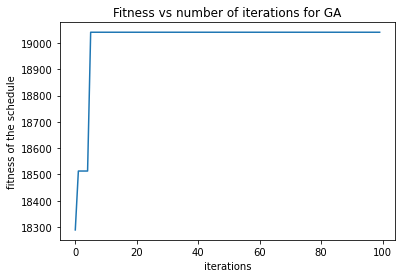

In [53]:
#Plotting the fitness against iterations
plt.plot(iteration_fitness1['fitness'])

plt.xlabel('iterations')
plt.ylabel('fitness of the schedule')

plt.title('Fitness vs number of iterations for GA')

plt.show()

In [54]:
#Returning the test points of the best schedule
best=schedule[-1][1]

In [55]:
best.sort(reverse=True,key=myFunc1)

In [56]:
print_detectors(best)

The optimized locations of the detectors are:
By standing at location: (-33.594312, 151.059473) the detector catches 1000 vehicles between time 16:00:00-19:45:00
By standing at location: (-33.650067, 151.0338) the detector catches 1000 vehicles between time 16:00:00-19:45:00
By standing at location: (-33.891495, 151.21685) the detector catches 960 vehicles between time 08:00:00-12:00:00
By standing at location: (-33.569935, 150.733921) the detector catches 960 vehicles between time 07:00:00-11:00:00
By standing at location: (-33.8643, 151.117979) the detector catches 960 vehicles between time 08:00:00-12:00:00
By standing at location: (-33.645941, 151.045433) the detector catches 960 vehicles between time 07:00:00-11:00:00
By standing at location: (-33.758699, 151.049087) the detector catches 900 vehicles between time 19:00:00-22:45:00
By standing at location: (-33.764062, 151.025601) the detector catches 900 vehicles between time 15:00:00-18:45:00
By standing at location: (-33.883483,

In [57]:
#Creating a list to store the detector's coordinates:
detector_coordinates=[]

print_offender_detector(detector_coordinates,best)

1 offenders are caught by standing at (-33.594312, 151.059473) between time 16:00:00-19:45:00
Offender 40 at time 17:12:21
1 offenders are caught by standing at (-33.650067, 151.0338) between time 16:00:00-19:45:00
Offender 41 at time 19:31:54
1 offenders are caught by standing at (-33.870779, 151.142172) between time 15:00:00-17:45:00
Offender 39 at time 17:03:51
TOTAL OFFENDERS CAUGHT ARE:3


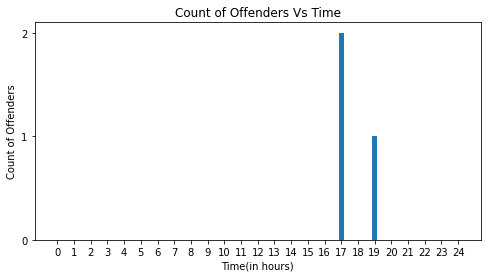

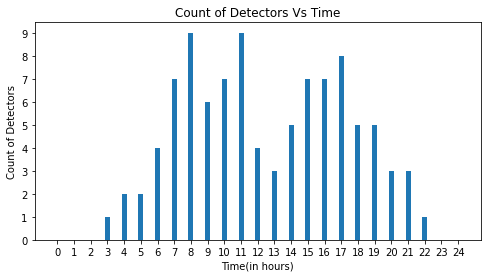

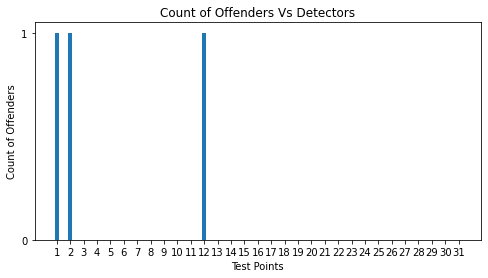

TEST POINT NUMBERS WITH THEIR POSITIONS:
Test Point 1 at:(-33.594312, 151.059473)
Test Point 2 at:(-33.650067, 151.0338)
Test Point 3 at:(-33.891495, 151.21685)
Test Point 4 at:(-33.569935, 150.733921)
Test Point 5 at:(-33.8643, 151.117979)
Test Point 6 at:(-33.645941, 151.045433)
Test Point 7 at:(-33.758699, 151.049087)
Test Point 8 at:(-33.764062, 151.025601)
Test Point 9 at:(-33.883483, 151.120685)
Test Point 10 at:(-33.760571, 150.735222)
Test Point 11 at:(-33.729324, 150.660181)
Test Point 12 at:(-33.870779, 151.142172)
Test Point 13 at:(-33.713091, 150.731291)
Test Point 14 at:(-33.584658, 151.01296)
Test Point 15 at:(-33.57797, 151.013662)
Test Point 16 at:(-33.73268, 150.718038)
Test Point 17 at:(-33.730159, 151.160881)
Test Point 18 at:(-33.718107, 150.925795)
Test Point 19 at:(-33.875129, 151.217492)
Test Point 20 at:(-33.734788, 150.885978)
Test Point 21 at:(-33.751621, 150.949934)
Test Point 22 at:(-33.649459, 150.791767)
Test Point 23 at:(-33.742148, 151.200027)
Test Point

In [81]:
off_vs_time(best)
det_vs_time(best)
det_vs_off(best,detector_coordinates)

In [87]:
#Map to plot the detectors and the offenders caught:
detector_offender=folium.Map(location=sydney,zoom_start=11)
detector=folium.Map(location=sydney,zoom_start=11)
detector_offender.add_child(folium.LatLngPopup())

In [88]:
plot_detector_offender(detector_offender,best,off_id,route_coordinates_with_time,offenders_coordinates,detector_coordinates)
plot_detector(detector,best,off_id,route_coordinates_with_time,offenders_coordinates,detector_coordinates)

In [89]:
detector_offender

In [90]:
detector

### For June 3:

In [135]:
june_3=pd.read_csv('June 3 editted(2).csv')

#Finding the lat and longs of  the roads
lat_long_roads_3=find_ll_of_road(june_3)

In [137]:
#Creating initial population with 10 schedules printing the total working hours for each population
solutions=[]
for i in range(10):
    s=create_initialPopulation(detector_count,lat_long_roads,june_3)
    solutions.append(s)

Total time:78.75
Total time:79.75
Total time:78.25
Total time:80.0
Total time:76.75
Total time:76.25
Total time:77.25
Total time:79.25
Total time:77.25
Total time:79.75


In [138]:
solutions[:2]

[[[(-33.813316, 150.812077), [datetime.time(1, 0), datetime.time(2, 0)], 240],
  [(-33.87449, 150.844428),
   [datetime.time(10, 0), datetime.time(12, 15)],
   540],
  [(-33.700173, 151.027771),
   [datetime.time(19, 0), datetime.time(20, 15)],
   300],
  [(-33.58139, 150.947349), [datetime.time(14, 0), datetime.time(15, 0)], 240],
  [(-33.771206, 151.160974), [datetime.time(0, 0), datetime.time(3, 30)], 762],
  [(-33.947077, 150.877249),
   [datetime.time(13, 0), datetime.time(15, 15)],
   540],
  [(-33.934375, 151.131049), [datetime.time(1, 0), datetime.time(4, 45)], 900],
  [(-33.751271, 151.065195), [datetime.time(2, 0), datetime.time(5, 30)], 589],
  [(-33.806363, 151.153032),
   [datetime.time(19, 0), datetime.time(23, 0)],
   960],
  [(-33.76337, 151.080031),
   [datetime.time(17, 0), datetime.time(18, 45)],
   420],
  [(-33.84542, 151.211886),
   [datetime.time(11, 0), datetime.time(12, 45)],
   420],
  [(-33.613266, 150.948161),
   [datetime.time(16, 0), datetime.time(16, 30)]

In [139]:
#Initializing fitness
fitness=0

#To store the offender id caught by each detector, create a dictionary
off_id={}

In [140]:
best_june3,plot_data_june3,off_id=ga(solutions,100,alpha,june_3,off_id) 

ITERATION NUMBER: 1---------------------------------------------


C:\Users\user\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


Sorting......................
Maximum fitness is 20381
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 2---------------------------------------------
Sorting......................
Maximum fitness is 20381
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 3---------------------------------------------
Sorting......................
Maximum fitness is 20560
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 4---------------------------------------------
Sorting......................
Maximum fitness is 20560
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 5---------------------------------------------
Sorting......................
Maximum fitness is 20560
Creating unaltered popula

ITERATION NUMBER: 37---------------------------------------------
Sorting......................
Maximum fitness is 20931
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 38---------------------------------------------
Sorting......................
Maximum fitness is 20931
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 39---------------------------------------------
Sorting......................
Maximum fitness is 20931
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 40---------------------------------------------
Sorting......................
Maximum fitness is 20931
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 41---------------------------------------------
Sorting...

ITERATION NUMBER: 73---------------------------------------------
Sorting......................
Maximum fitness is 20931
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 74---------------------------------------------
Sorting......................
Maximum fitness is 20931
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 75---------------------------------------------
Sorting......................
Maximum fitness is 20931
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 76---------------------------------------------
Sorting......................
Maximum fitness is 20931
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 77---------------------------------------------
Sorting...

In [141]:
#Creating dataframe of fitness with number of iterations
iteration_fitness2=pd.DataFrame(plot_data_june3,columns=['fitness'])

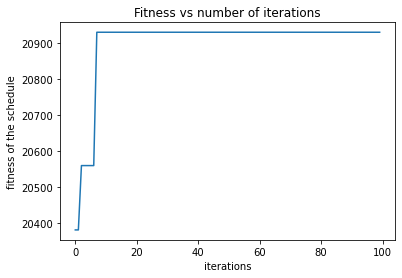

In [142]:
#Plotting the fitness against iterations
plt.plot(iteration_fitness2['fitness'])

plt.xlabel('iterations')
plt.ylabel('fitness of the schedule')

plt.title('Fitness vs number of iterations')

plt.show()

In [143]:
#Returning the test points of the best schedule
best_june3=best_june3[-1][1]
best_june3.sort(reverse=True,key=myFunc1)

In [144]:
print_detectors(best_june3)

The optimized locations of the detectors are:
By standing at location: (-33.685158, 151.027532) the detector catches 1080 vehicles between time 19:00:00-22:15:00
By standing at location: (-33.762794, 151.077841) the detector catches 1080 vehicles between time 16:00:00-19:15:00
By standing at location: (-33.859914, 151.205751) the detector catches 1040 vehicles between time 17:00:00-20:30:00
By standing at location: (-33.788629, 151.134652) the detector catches 1032 vehicles between time 00:00:00-02:30:00
By standing at location: (-33.764131, 151.092198) the detector catches 960 vehicles between time 07:00:00-11:00:00
By standing at location: (-33.942944, 151.000186) the detector catches 960 vehicles between time 14:00:00-18:00:00
By standing at location: (-33.940536, 151.084008) the detector catches 940 vehicles between time 09:00:00-12:30:00
By standing at location: (-33.936227, 151.117285) the detector catches 940 vehicles between time 01:00:00-04:30:00
By standing at location: (-33.

In [145]:
#Creating a list to store the detector's coordinates:
detector_coordinates_june3=[]

print_offender_detector(detector_coordinates_june3,best_june3)

3 offenders are caught by standing at (-33.685158, 151.027532) between time 19:00:00-22:15:00
Offender 37 at time 20:41:15
Offender 40 at time 20:14:39
Offender 81 at time 19:23:28
3 offenders are caught by standing at (-33.762794, 151.077841) between time 16:00:00-19:15:00
Offender 28 at time 17:35:48
Offender 29 at time 17:47:29
Offender 34 at time 18:47:18
2 offenders are caught by standing at (-33.859914, 151.205751) between time 17:00:00-20:30:00
Offender 30 at time 17:14:08
Offender 39 at time 20:27:25
5 offenders are caught by standing at (-33.788629, 151.134652) between time 00:00:00-02:30:00
Offender 2 at time 00:22:33
Offender 4 at time 00:49:55
Offender 5 at time 00:29:30
Offender 10 at time 00:27:50
Offender 18 at time 02:16:37
1 offenders are caught by standing at (-33.940536, 151.084008) between time 09:00:00-12:30:00
Offender 25 at time 10:13:08
1 offenders are caught by standing at (-33.936227, 151.117285) between time 01:00:00-04:30:00
Offender 14 at time 03:53:54
3 of

In [ ]:
off_vs_time(best_june3)
det_vs_time(best_june3)
det_vs_off(best_june3,detector_coordinates_june3)

In [101]:
#Map to plot the detectors and the offenders caught:
detector_offender_june3=folium.Map(location=sydney,zoom_start=11)
detector_june3=folium.Map(location=sydney,zoom_start=11)
detector_offender_june3.add_child(folium.LatLngPopup())

In [102]:
plot_detector_offender(detector_offender_june3,best_june3,off_id,route_coordinates_with_time,offenders_coordinates,detector_coordinates_june3)
plot_detector(detector_june3,best_june3,off_id,route_coordinates_with_time,offenders_coordinates,detector_coordinates_june3)

In [103]:
detector_offender_june3

In [104]:
detector_june3

### For June 4:

In [105]:
june_4=pd.read_csv('June 4 editted(2).csv')

#Finding the lat and longs of  the roads
lat_long_roads_4=find_ll_of_road(june_4)

In [106]:
#Creating initial population with 10 schedules printing the total working hours for each population
solutions=[]
for i in range(10):
    s=create_initialPopulation(detector_count,lat_long_roads,june_4)
    solutions.append(s)

Total time:78.5
Total time:77.0
Total time:80.0
Total time:79.0
Total time:78.75
Total time:80.0
Total time:79.25
Total time:78.75
Total time:78.25
Total time:80.0


In [107]:
solutions[:2]

[[[(-33.807038, 151.154074), [datetime.time(6, 0), datetime.time(8, 15)], 540],
  [(-33.791823, 150.997799), [datetime.time(5, 0), datetime.time(7, 30)], 600],
  [(-33.85471, 151.062512), [datetime.time(8, 0), datetime.time(10, 15)], 540],
  [(-33.702244, 151.027066),
   [datetime.time(17, 0), datetime.time(19, 45)],
   660],
  [(-33.76906, 150.965943), [datetime.time(15, 0), datetime.time(19, 0)], 960],
  [(-33.904151, 151.214977), [datetime.time(7, 0), datetime.time(9, 0)], 480],
  [(-33.69622, 151.03038), [datetime.time(12, 0), datetime.time(16, 0)], 960],
  [(-33.87402, 151.20169), [datetime.time(12, 0), datetime.time(13, 45)], 420],
  [(-33.689054, 151.029872),
   [datetime.time(14, 0), datetime.time(15, 30)],
   360],
  [(-33.709321, 151.175258),
   [datetime.time(12, 0), datetime.time(15, 15)],
   766],
  [(-33.661115, 151.005041), [datetime.time(3, 0), datetime.time(4, 15)], 156],
  [(-33.827229, 151.189133),
   [datetime.time(10, 0), datetime.time(12, 30)],
   11],
  [(-33.786

In [108]:
#Initializing fitness
fitness=0

#To store the offender id caught by each detector, create a dictionary
off_id={}

In [109]:
best_june4,plot_data_june4,off_id=ga(solutions,50,alpha,june_4,off_id) 

ITERATION NUMBER: 1---------------------------------------------


C:\Users\user\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


Sorting......................
Maximum fitness is 20550
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 2---------------------------------------------
Sorting......................
Maximum fitness is 20550
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 3---------------------------------------------
Sorting......................
Maximum fitness is 20550
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 4---------------------------------------------
Sorting......................
Maximum fitness is 20550
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 5---------------------------------------------
Sorting......................
Maximum fitness is 20550
Creating unaltered popula

ITERATION NUMBER: 37---------------------------------------------
Sorting......................
Maximum fitness is 20550
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 38---------------------------------------------
Sorting......................
Maximum fitness is 20550
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 39---------------------------------------------
Sorting......................
Maximum fitness is 20550
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 40---------------------------------------------
Sorting......................
Maximum fitness is 20550
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 41---------------------------------------------
Sorting...

In [110]:
#Creating dataframe of fitness with number of iterations
iteration_fitness3=pd.DataFrame(plot_data_june4,columns=['fitness'])

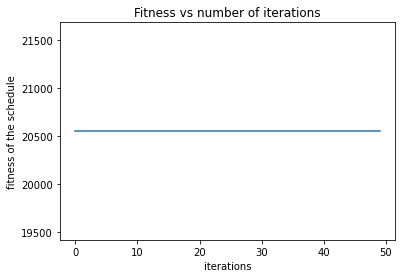

In [111]:
#Plotting the fitness against iterations
plt.plot(iteration_fitness3['fitness'])

plt.xlabel('iterations')
plt.ylabel('fitness of the schedule')

plt.title('Fitness vs number of iterations')

plt.show()

In [112]:
#Returning the test points of the best schedule
best_june4=best_june4[-1][1]
best_june4.sort(reverse=True,key=myFunc1)

In [113]:
print_detectors(best_june4)

The optimized locations of the detectors are:
By standing at location: (-33.896298, 150.83692) the detector catches 1060 vehicles between time 01:00:00-03:45:00
By standing at location: (-33.75743, 151.062753) the detector catches 1040 vehicles between time 05:00:00-08:30:00
By standing at location: (-33.825728, 151.212388) the detector catches 1040 vehicles between time 00:00:00-03:30:00
By standing at location: (-33.888798, 151.217582) the detector catches 994 vehicles between time 00:00:00-03:45:00
By standing at location: (-33.874833, 150.844087) the detector catches 960 vehicles between time 04:00:00-08:00:00
By standing at location: (-33.699594, 151.028105) the detector catches 960 vehicles between time 18:00:00-20:45:00
By standing at location: (-33.634725, 151.249279) the detector catches 940 vehicles between time 05:00:00-08:30:00
By standing at location: (-33.679977, 150.705012) the detector catches 940 vehicles between time 13:00:00-16:30:00
By standing at location: (-33.938

In [114]:
#Creating a list to store the detector's coordinates:
detector_coordinates_june4=[]

print_offender_detector(detector_coordinates_june4,best_june4)

4 offenders are caught by standing at (-33.896298, 150.83692) between time 01:00:00-03:45:00
Offender 9 at time 01:37:34
Offender 17 at time 02:50:47
Offender 56 at time 01:44:50
Offender 64 at time 03:09:49
2 offenders are caught by standing at (-33.75743, 151.062753) between time 05:00:00-08:30:00
Offender 21 at time 05:52:22
Offender 73 at time 07:34:25
2 offenders are caught by standing at (-33.825728, 151.212388) between time 00:00:00-03:30:00
Offender 12 at time 03:19:26
Offender 14 at time 02:46:38
1 offenders are caught by standing at (-33.888798, 151.217582) between time 00:00:00-03:45:00
Offender 12 at time 03:19:26
3 offenders are caught by standing at (-33.699594, 151.028105) between time 18:00:00-20:45:00
Offender 34 at time 19:21:23
Offender 81 at time 19:30:20
Offender 87 at time 20:35:16
1 offenders are caught by standing at (-33.634725, 151.249279) between time 05:00:00-08:30:00
Offender 70 at time 05:47:09
1 offenders are caught by standing at (-33.679977, 150.705012)

In [ ]:
off_vs_time(best_june4)
det_vs_time(best_june4)
det_vs_off(best_june4,detector_coordinates_june4)

In [115]:
#Map to plot the detectors and the offenders caught:
detector_offender_june4=folium.Map(location=sydney,zoom_start=11)
detector_june4=folium.Map(location=sydney,zoom_start=11)
detector_offender_june4.add_child(folium.LatLngPopup())

In [116]:
plot_detector_offender(detector_offender_june4,best_june4,off_id,route_coordinates_with_time,offenders_coordinates,detector_coordinates_june4)
plot_detector(detector_june4,best_june4,off_id,route_coordinates_with_time,offenders_coordinates,detector_coordinates_june4)

In [117]:
detector_offender_june4

In [118]:
detector_june4

### For June 5:

In [119]:
june_5=pd.read_csv('June 5 editted(2).csv')

#Finding the lat and longs of  the roads
lat_long_roads_5=find_ll_of_road(june_5)

In [120]:
#Creating initial population with 10 schedules printing the total working hours for each population
solutions=[]
for i in range(10):
    s=create_initialPopulation(detector_count,lat_long_roads,june_5)
    solutions.append(s)

Total time:79.25
Total time:77.25
Total time:80.0
Total time:77.25
Total time:78.0
Total time:79.75
Total time:77.75
Total time:78.75
Total time:78.25
Total time:79.0


In [121]:
solutions[:2]

[[[(-33.697504, 150.927674),
   [datetime.time(9, 0), datetime.time(11, 30)],
   600],
  [(-33.835189, 151.210915), [datetime.time(5, 0), datetime.time(6, 30)], 360],
  [(-33.729031, 151.162575), [datetime.time(1, 0), datetime.time(2, 45)], 79],
  [(-33.8123, 151.177728), [datetime.time(19, 0), datetime.time(22, 45)], 795],
  [(-33.883874, 150.838129), [datetime.time(7, 0), datetime.time(9, 30)], 600],
  [(-33.762109, 151.0349), [datetime.time(9, 0), datetime.time(11, 30)], 600],
  [(-33.839772, 150.683803),
   [datetime.time(11, 0), datetime.time(14, 15)],
   780],
  [(-33.8644, 151.066094), [datetime.time(19, 0), datetime.time(22, 30)], 840],
  [(-33.79861, 151.139407),
   [datetime.time(15, 0), datetime.time(15, 30)],
   120],
  [(-33.856335, 151.070681), [datetime.time(2, 0), datetime.time(3, 15)], 248],
  [(-33.759013, 151.044977),
   [datetime.time(17, 0), datetime.time(19, 45)],
   660],
  [(-33.893141, 150.835254), [datetime.time(8, 0), datetime.time(9, 15)], 300],
  [(-33.7291

In [122]:
#Initializing fitness
fitness=0

#To store the offender id caught by each detector, create a dictionary
off_id={}

In [123]:
best_june5,plot_data_june5,off_id=ga(solutions,50,alpha,june_5,off_id)

ITERATION NUMBER: 1---------------------------------------------


C:\Users\user\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


Sorting......................
Maximum fitness is 20402
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 2---------------------------------------------
Sorting......................
Maximum fitness is 20402
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 3---------------------------------------------
Sorting......................
Maximum fitness is 20402
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 4---------------------------------------------
Sorting......................
Maximum fitness is 20402
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 5---------------------------------------------
Sorting......................
Maximum fitness is 20402
Creating unaltered popula

ITERATION NUMBER: 37---------------------------------------------
Sorting......................
Maximum fitness is 20402
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 38---------------------------------------------
Sorting......................
Maximum fitness is 20402
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 39---------------------------------------------
Sorting......................
Maximum fitness is 20402
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 40---------------------------------------------
Sorting......................
Maximum fitness is 20402
Creating unaltered population.............................
Creating new population...........................
ITERATION NUMBER: 41---------------------------------------------
Sorting...

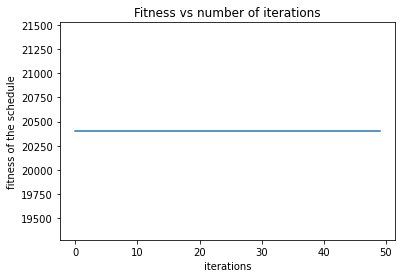

In [124]:
#Creating dataframe of fitness with number of iterations
iteration_fitness4=pd.DataFrame(plot_data_june5,columns=['fitness'])
#Plotting the fitness against iterations
plt.plot(iteration_fitness4['fitness'])

plt.xlabel('iterations')
plt.ylabel('fitness of the schedule')

plt.title('Fitness vs number of iterations')

plt.show()

In [125]:
#Returning the test points of the best schedule
best_june5=best_june5[-1][1]
best_june5.sort(reverse=True,key=myFunc1)

In [126]:
print_detectors(best_june5)

The optimized locations of the detectors are:
By standing at location: (-33.935217, 151.14378) the detector catches 1100 vehicles between time 17:00:00-20:45:00
By standing at location: (-33.943006, 151.055502) the detector catches 1060 vehicles between time 00:00:00-02:45:00
By standing at location: (-33.934115, 151.160112) the detector catches 980 vehicles between time 05:00:00-08:15:00
By standing at location: (-33.814454, 151.022552) the detector catches 960 vehicles between time 09:00:00-13:00:00
By standing at location: (-33.774792, 151.001279) the detector catches 960 vehicles between time 18:00:00-22:00:00
By standing at location: (-33.916377, 151.063527) the detector catches 920 vehicles between time 05:00:00-08:00:00
By standing at location: (-34.040293, 150.744221) the detector catches 900 vehicles between time 09:00:00-12:45:00
By standing at location: (-33.947082, 150.969994) the detector catches 880 vehicles between time 03:00:00-06:15:00
By standing at location: (-33.583

In [127]:
#Creating a list to store the detector's coordinates:
detector_coordinates_june5=[]

print_offender_detector(detector_coordinates_june5,best_june5)

2 offenders are caught by standing at (-33.935217, 151.14378) between time 17:00:00-20:45:00
Offender 31 at time 19:40:18
Offender 32 at time 18:13:31
4 offenders are caught by standing at (-33.943006, 151.055502) between time 00:00:00-02:45:00
Offender 3 at time 01:53:41
Offender 6 at time 00:24:28
Offender 9 at time 01:37:34
Offender 10 at time 00:46:37
2 offenders are caught by standing at (-33.934115, 151.160112) between time 05:00:00-08:15:00
Offender 22 at time 07:05:53
Offender 23 at time 06:24:14
2 offenders are caught by standing at (-33.916377, 151.063527) between time 05:00:00-08:00:00
Offender 22 at time 07:05:53
Offender 23 at time 06:24:14
1 offenders are caught by standing at (-33.947082, 150.969994) between time 03:00:00-06:15:00
Offender 19 at time 05:29:07
1 offenders are caught by standing at (-33.583213, 150.722948) between time 18:00:00-21:15:00
Offender 91 at time 20:29:05
1 offenders are caught by standing at (-33.886529, 150.836227) between time 10:00:00-13:15:0

In [ ]:
off_vs_time(best_june5)
det_vs_time(best_june5)
det_vs_off(best_june5,detector_coordinates_june5)

In [128]:
#Map to plot the detectors and the offenders caught:
detector_offender_june5=folium.Map(location=sydney,zoom_start=11)
detector_june5=folium.Map(location=sydney,zoom_start=11)
detector_offender_june5.add_child(folium.LatLngPopup())

In [129]:
plot_detector_offender(detector_offender_june5,best_june5,off_id,route_coordinates_with_time,offenders_coordinates,detector_coordinates_june5)
plot_detector(detector_june5,best_june5,off_id,route_coordinates_with_time,offenders_coordinates,detector_coordinates_june5)

In [130]:
detector_offender_june5

In [ ]:
detector_june5

# PARTICLE SWARM OPTIMISATION:

### Initial Parameters:

In [131]:
def initial_params(solutions,schedule_with_fitness):
    #Now we have the fitness values of each schedule in the list 'schedule_with_fitness'
    #Assign the value of p_best
    p_best_position=solutions
    p_best_fitness=[m[0] for m in schedule_with_fitness]

    #Get the index of the fitness having maximum value, assign value to g_best
    gbest_index=np.argmax(p_best_fitness)
    #Access the schedule with the largest fitness
    gbest_position=p_best_position[gbest_index]
    
    # Velocity (starting from 0 speed)
    velocity_lat = [[0.0 for j in range(detector_count)] for i in range(10)]
    velocity_long=[[0.0 for j in range(detector_count)] for i in range(10)]
    
    #Return these initial parameters
    return p_best_position,p_best_fitness,gbest_index,gbest_position,velocity_lat,velocity_long

### Combined Fitness:

In [132]:
def combined_fit(solutions,off_id):
    #Iterating through each schedule
    schedule_with_fitness=[] #Stores fitnesses of each schedule
    off_id_schedule=[]
    for s in solutions:
        off_id={}
        tot_fitness=0 #Total fitness of the schedule
        combined_fitness=0 
        soltn_with_fitness=[] #Stores fitnesses of each test point

        #Iterating through each test point in the schedule
        for j in s:

            #combined_fitness=alpha*x1+x2
            fit,off_id=find_fitness(j[0][0],j[0][1],j[1],off_id)
            combined_fitness=alpha*fit+j[2]

            #Append the fitness of the TEST POINT with the TEST POINT
            soltn_with_fitness.append((combined_fitness,j))

            #Finding the total fitness
            tot_fitness+=combined_fitness
        
        off_id_schedule.append(off_id)
        #Append the fitness of the SCHEDULE and the schedule to the list
        schedule_with_fitness.append((tot_fitness,soltn_with_fitness))
    #Find index of schedule with maximum fitness
    ind=np.argmax(schedule_with_fitness,axis=0)[0]
    off_id=off_id_schedule[ind]
    
        
    return schedule_with_fitness,off_id

### Update Velocity:

In [133]:
def update_velocity(particle, velocity_lat,velocity_long, pbest, gbest, w_min=0.5, max=1.0, c=0.1):
    # Initialise new velocity array
    num_particle =min(len(pbest),len(gbest),len(particle))
    new_velocity_lat = np.array([0.0 for i in range(detector_count)])
    new_velocity_long = np.array([0.0 for i in range(detector_count)])
    # Randomly generate r1, r2 and inertia weight from normal distribution
    r1 = random.uniform(0,max)
    r2 = random.uniform(0,max)
    w = random.uniform(w_min,max)
    c1 = c
    c2 = c
    # Calculate new velocity
    for i in range(num_particle):
        new_velocity_lat[i] = w*velocity_lat[i]+c1*r1*(abs(pbest[i][0][0]-particle[i][0][0]))+c2*r2*(abs(gbest[i][0][0]-particle[i][0][0]))
        new_velocity_long[i]=w*velocity_long[i]+c1*r1*(abs(pbest[i][0][1]-particle[i][0][1]))+c2*r2*(abs(gbest[i][0][1]-particle[i][0][1]))
    return new_velocity_lat,new_velocity_long

### Update Position:

In [135]:
def update_position(particle, velocity_lat,velocity_long,june_data):
    new_particle=[]
    tot_time=0.0
    # Move particles by adding velocity
    for i in range(len(particle)):
        lat=particle[i][0][0]
        long=particle[i][0][1]
        
        newLat=round(velocity_lat[i]+lat,6)
        newLong=round(velocity_long[i]+long,6)
        
        #Checking if lat and long are between their maximum and minimum values
        #If they are not, then bring them between the latutude and longitude ranges
        if newLat<lat_range[0] or newLat>lat_range[1] or newLong<long_range[0] or newLong>long_range[1] or (newLat,newLong) not in points_off or check_intersection(newLat,newLong)==True:
            newLatLong=random.choice(points_off)
            newLat=newLatLong[0]
            newLong=newLatLong[1]
            
        #Randomly generate a range
        rnge=generate_random_timeRange()
                
        rnge_conv=delta_to_time(rnge)
        #Add it with the total time
        tot_time+=(rnge_conv.hour+(rnge_conv.minute)/60)
        if tot_time>max_hours:
            return new_particle

        lower_t=random.randint(0,24-(upper_limit.hour+1))
        lower_t=datetime.time(hour=lower_t,minute=0,second=0)
        upper_t=add_times(lower_t,rnge)

        #Finding vehicle count
        closer_road=find_closest_road(lat_long_roads,newLat,newLong)

        #Analyzing traffic of the road
        vehicles=num_of_vehicles(june_data,lower_t,upper_t,closer_road)
        
        new_particle.append([(newLat,newLong),[lower_t,upper_t],vehicles])
    
    return new_particle

### Particle Swarm Optimization:

In [136]:
#function to perform genetic algorithm
def pso(solutions,num_iter,alpha,june_data,velocity_lat,velocity_long,p_best_position,gbest_position,p_best_fitness,schedule_with_fitness,off_id):
    """"
    solutions is the initial population
    num_iter:number of generations
    velocity_lat,velocity_long:Initial velocities for latitudes and longitudes
    p_best_position:best individual position
    gbest_position:best global position
    """
    
    #Create a list that stores the best ftiness of each iteration
    plot_data=[]
    
    #-----------------------------------------------------BEGIN ITERATION----------------------------------------------------
    for i in range(num_iter):
        
        #Creating a list of new particles
        newGen=[]
        
        print('ITERATION NUMBER: '+str(i+1)+"---------------------------------------------")
        
        #--------------------------------------------------UPDATE VELOCITY AND POSITION------------------------------------------------
        
        print('Updating Velocity and position.................')
        #Update for each population:
        for n in range(10):
            
            #Update Velocity of each solution
            velocity_lat[n],velocity_long[n]=update_velocity(solutions[n],velocity_lat[n],velocity_long[n],p_best_position[n],gbest_position)
            
            #Update the position 
            newGen.append(update_position(solutions[n],velocity_lat[n],velocity_long[n],june_2))
            
        #-------------------------------------------------CALCULATE FITNESS-----------------------------------------------------
        off_id_newGen={}
        #Find the fitness
        schedule_with_fitness_newGen,off_id_newGen=combined_fit(newGen,off_id_newGen)
        
        print('Updating p_best and g_best...........')
        p_best_fitness_newGen=[m[0] for m in schedule_with_fitness_newGen]
        
        #Compare the fitness of present Gen with previous Gen
        if max(p_best_fitness_newGen)>max(p_best_fitness):
            solutions=newGen
            schedule_with_fitness=schedule_with_fitness_newGen
            p_best_fitness=p_best_fitness_newGen
            off_id=off_id_newGen
        
        plot_data.append(max(p_best_fitness))
        print('Maximum fitness is '+str(max(p_best_fitness)))
        
        #Updating g_best
        gbest_index=np.argmax(p_best_fitness)
        gbest_position=p_best_position[gbest_index]
        
                       
    return schedule_with_fitness[gbest_index][1],plot_data,off_id

## Running the PSO:

### For June 2:

In [137]:
#Creating initial population with 10 schedules
solutions=[]
for i in range(10):
    s=create_initialPopulation(detector_count,lat_long_roads,june_2)
    solutions.append(s)

Total time:80.0
Total time:79.5
Total time:77.5
Total time:79.0
Total time:79.75
Total time:78.25
Total time:76.75
Total time:79.5
Total time:78.25
Total time:79.5


In [138]:
solutions[:2]

[[[(-33.961057, 150.889021),
   [datetime.time(7, 0), datetime.time(10, 30)],
   840],
  [(-33.756493, 150.847829), [datetime.time(1, 0), datetime.time(5, 0)], 312],
  [(-33.785217, 150.777173), [datetime.time(8, 0), datetime.time(9, 0)], 240],
  [(-33.767007, 150.710032),
   [datetime.time(13, 0), datetime.time(15, 15)],
   540],
  [(-33.94418, 151.190043), [datetime.time(6, 0), datetime.time(8, 45)], 660],
  [(-33.936507, 151.150667), [datetime.time(5, 0), datetime.time(8, 30)], 840],
  [(-33.764322, 151.092372),
   [datetime.time(17, 0), datetime.time(19, 15)],
   540],
  [(-33.765929, 151.011063),
   [datetime.time(11, 0), datetime.time(12, 0)],
   240],
  [(-33.810263, 151.177616), [datetime.time(0, 0), datetime.time(3, 30)], 140],
  [(-33.928405, 151.167325),
   [datetime.time(8, 0), datetime.time(10, 45)],
   660],
  [(-33.938156, 150.878231), [datetime.time(2, 0), datetime.time(3, 30)], 272],
  [(-33.896099, 150.990637),
   [datetime.time(19, 0), datetime.time(19, 30)],
   120]

In [139]:
#Initializing fitness
fitness=0

#To store the offender id caught by each detector, create a dictionary
off_id={}

In [140]:
schedule_with_fitness,off_id=combined_fit(solutions,off_id)

C:\Users\user\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [141]:
p_best_position,p_best_fitness,gbest_index,gbest_position,velocity_lat,velocity_long=initial_params(solutions,schedule_with_fitness)

In [142]:
best_pso,plot_data_pso,off_id=pso(solutions,50,alpha,june_2,velocity_lat,velocity_long,p_best_position,gbest_position,p_best_fitness,schedule_with_fitness,off_id)

ITERATION NUMBER: 1---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 19650
ITERATION NUMBER: 2---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 19650
ITERATION NUMBER: 3---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 19981
ITERATION NUMBER: 4---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 19981
ITERATION NUMBER: 5---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 19981
ITERATION NUMBER: 6---------------------------------------------
Updating Velocity and position.................
Updatin

Updating p_best and g_best...........
Maximum fitness is 20368
ITERATION NUMBER: 48---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20368
ITERATION NUMBER: 49---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20368
ITERATION NUMBER: 50---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20368


In [143]:
#Creating dataframe of fitness with number of iterations
iteration_fitness1=pd.DataFrame(plot_data_pso,columns=['fitness'])

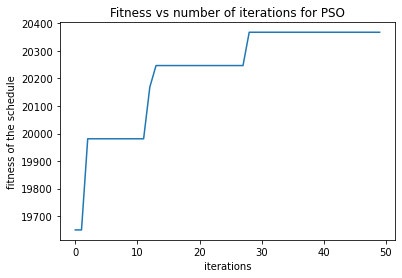

In [144]:
#Plotting the fitness against iterations
plt.plot(iteration_fitness1['fitness'])

plt.xlabel('iterations')
plt.ylabel('fitness of the schedule')

plt.title('Fitness vs number of iterations for PSO')

plt.show()

In [145]:
best_pso.sort(reverse=True,key=myFunc1)

In [146]:
print_detectors(best_pso)

The optimized locations of the detectors are:
By standing at location: (-33.936255, 151.128648) the detector catches 1600 vehicles between time 00:00:00-03:45:00
By standing at location: (-33.832067, 151.212363) the detector catches 1560 vehicles between time 19:00:00-23:00:00
By standing at location: (-33.715111, 151.014468) the detector catches 1160 vehicles between time 17:00:00-21:00:00
By standing at location: (-33.886255, 151.217982) the detector catches 960 vehicles between time 05:00:00-09:00:00
By standing at location: (-33.802705, 151.146266) the detector catches 840 vehicles between time 10:00:00-13:30:00
By standing at location: (-33.689282, 151.030121) the detector catches 840 vehicles between time 04:00:00-07:30:00
By standing at location: (-33.732172, 150.970536) the detector catches 820 vehicles between time 10:00:00-13:00:00
By standing at location: (-33.936862, 151.013209) the detector catches 780 vehicles between time 10:00:00-13:15:00
By standing at location: (-33.9

In [147]:
#Creating a list to store the detector's coordinates:
detector_coordinates_pso=[]

print_offender_detector(detector_coordinates_pso,best_pso)

7 offenders are caught by standing at (-33.936255, 151.128648) between time 00:00:00-03:45:00
Offender 3 at time 01:53:41
Offender 4 at time 00:25:04
Offender 6 at time 00:24:28
Offender 9 at time 01:37:34
Offender 10 at time 00:46:37
Offender 16 at time 02:47:27
Offender 17 at time 02:50:47
6 offenders are caught by standing at (-33.832067, 151.212363) between time 19:00:00-23:00:00
Offender 38 at time 20:57:58
Offender 40 at time 21:42:45
Offender 41 at time 20:08:13
Offender 49 at time 22:45:22
Offender 83 at time 19:49:27
Offender 91 at time 20:29:05
2 offenders are caught by standing at (-33.715111, 151.014468) between time 17:00:00-21:00:00
Offender 34 at time 19:21:23
Offender 87 at time 20:35:16
1 offenders are caught by standing at (-33.732172, 150.970536) between time 10:00:00-13:00:00
Offender 76 at time 12:03:27
1 offenders are caught by standing at (-33.956849, 150.875979) between time 04:00:00-06:30:00
Offender 19 at time 05:29:07
1 offenders are caught by standing at (-3

In [ ]:
off_vs_time(best_pso)
det_vs_time(best_pso)
det_vs_off(best_pso,detector_coordinates_pso)

In [148]:
#Map to plot the detectors and the offenders caught:
detector_offender_pso=folium.Map(location=sydney,zoom_start=11)
detector_pso=folium.Map(location=sydney,zoom_start=11)
detector_offender_pso.add_child(folium.LatLngPopup())

In [149]:
plot_detector_offender(detector_offender_pso,best_pso,off_id,route_coordinates_with_time,offenders_coordinates,detector_coordinates_pso)
plot_detector(detector_pso,best_pso,off_id,route_coordinates_with_time,offenders_coordinates,detector_coordinates_pso)

In [150]:
detector_offender_pso

In [151]:
detector_pso

### For June 3:

In [152]:
#Creating initial population with 10 schedules printing the total working hours for each population
solutions=[]
for i in range(10):
    s=create_initialPopulation(detector_count,lat_long_roads,june_3)
    solutions.append(s)

Total time:78.25
Total time:79.75
Total time:76.25
Total time:79.75
Total time:79.75
Total time:77.75
Total time:78.75
Total time:76.25
Total time:78.75
Total time:77.25


In [153]:
solutions[:2]

[[[(-33.937609, 151.15289),
   [datetime.time(14, 0), datetime.time(15, 15)],
   300],
  [(-33.807648, 150.932499), [datetime.time(1, 0), datetime.time(3, 45)], 660],
  [(-33.921984, 151.219266),
   [datetime.time(13, 0), datetime.time(15, 0)],
   480],
  [(-33.788646, 151.179842), [datetime.time(6, 0), datetime.time(7, 30)], 360],
  [(-33.661803, 150.797837), [datetime.time(0, 0), datetime.time(3, 15)], 780],
  [(-33.747425, 150.950131), [datetime.time(5, 0), datetime.time(8, 45)], 900],
  [(-33.778332, 150.857472), [datetime.time(3, 0), datetime.time(3, 45)], 180],
  [(-33.78266, 150.688893), [datetime.time(2, 0), datetime.time(3, 15)], 300],
  [(-33.834467, 151.027518),
   [datetime.time(19, 0), datetime.time(22, 15)],
   780],
  [(-33.812596, 151.173926),
   [datetime.time(14, 0), datetime.time(16, 15)],
   540],
  [(-33.796265, 151.173229), [datetime.time(8, 0), datetime.time(11, 0)], 720],
  [(-33.796703, 150.986473),
   [datetime.time(10, 0), datetime.time(12, 45)],
   660],
  [

In [154]:
#Initializing fitness
fitness=0

#To store the offender id caught by each detector, create a dictionary
off_id={}

In [155]:
schedule_with_fitness,off_id=combined_fit(solutions,off_id)

C:\Users\user\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [156]:
p_best_position,p_best_fitness,gbest_index,gbest_position,velocity_lat,velocity_long=initial_params(solutions,schedule_with_fitness)

In [157]:
best_pso_june3,plot_data_pso_june3,off_id=pso(solutions,50,alpha,june_3,velocity_lat,velocity_long,p_best_position,gbest_position,p_best_fitness,schedule_with_fitness,off_id)

ITERATION NUMBER: 1---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20100
ITERATION NUMBER: 2---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20100
ITERATION NUMBER: 3---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20100
ITERATION NUMBER: 4---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20100
ITERATION NUMBER: 5---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20271
ITERATION NUMBER: 6---------------------------------------------
Updating Velocity and position.................
Updatin

Updating p_best and g_best...........
Maximum fitness is 20813
ITERATION NUMBER: 48---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20813
ITERATION NUMBER: 49---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20813
ITERATION NUMBER: 50---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20813


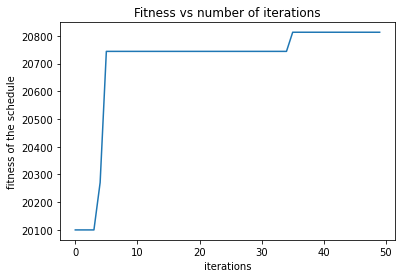

In [158]:
#Creating dataframe of fitness with number of iterations
iteration_fitness2=pd.DataFrame(plot_data_pso_june3,columns=['fitness'])

#Plotting the fitness against iterations
plt.plot(iteration_fitness2['fitness'])

plt.xlabel('iterations')
plt.ylabel('fitness of the schedule')

plt.title('Fitness vs number of iterations')

plt.show()

In [159]:
best_pso_june3.sort(reverse=True,key=myFunc1)

In [160]:
print_detectors(best_pso_june3)

The optimized locations of the detectors are:
By standing at location: (-33.699726, 151.028018) the detector catches 1360 vehicles between time 18:00:00-22:00:00
By standing at location: (-33.844119, 151.046277) the detector catches 1300 vehicles between time 17:00:00-20:45:00
By standing at location: (-33.739621, 151.068142) the detector catches 1060 vehicles between time 14:00:00-18:00:00
By standing at location: (-33.604094, 150.823126) the detector catches 1000 vehicles between time 19:00:00-22:45:00
By standing at location: (-33.73492, 150.962556) the detector catches 1000 vehicles between time 16:00:00-19:45:00
By standing at location: (-33.764136, 151.083052) the detector catches 960 vehicles between time 13:00:00-17:00:00
By standing at location: (-33.793851, 151.012691) the detector catches 940 vehicles between time 15:00:00-18:30:00
By standing at location: (-33.640418, 151.040568) the detector catches 920 vehicles between time 17:00:00-20:00:00
By standing at location: (-33.

In [161]:
#Creating a list to store the detector's coordinates:
detector_coordinates_pso_june3=[]

print_offender_detector(detector_coordinates_pso_june3,best_pso_june3)

4 offenders are caught by standing at (-33.699726, 151.028018) between time 18:00:00-22:00:00
Offender 34 at time 19:21:23
Offender 40 at time 21:42:45
Offender 81 at time 19:30:20
Offender 87 at time 20:35:16
4 offenders are caught by standing at (-33.844119, 151.046277) between time 17:00:00-20:45:00
Offender 32 at time 18:13:31
Offender 33 at time 18:12:31
Offender 36 at time 20:14:49
Offender 90 at time 20:44:51
1 offenders are caught by standing at (-33.739621, 151.068142) between time 14:00:00-18:00:00
Offender 79 at time 16:47:11
1 offenders are caught by standing at (-33.604094, 150.823126) between time 19:00:00-22:45:00
Offender 83 at time 19:49:27
1 offenders are caught by standing at (-33.73492, 150.962556) between time 16:00:00-19:45:00
Offender 34 at time 19:21:23
1 offenders are caught by standing at (-33.793851, 151.012691) between time 15:00:00-18:30:00
Offender 32 at time 18:13:31
2 offenders are caught by standing at (-33.640418, 151.040568) between time 17:00:00-20:0

In [ ]:
off_vs_time(best_pso_june3)
det_vs_time(best_pso_june3)
det_vs_off(best_pso_june3,detector_coordinates_pso_june3)

In [162]:
#Map to plot the detectors and the offenders caught:
detector_offender_pso_june3=folium.Map(location=sydney,zoom_start=11)
detector_pso_june3=folium.Map(location=sydney,zoom_start=11)
detector_offender_pso_june3.add_child(folium.LatLngPopup())

In [163]:
plot_detector_offender(detector_offender_pso_june3,best_pso_june3,off_id,route_coordinates_with_time,offenders_coordinates,detector_coordinates_pso_june3)
plot_detector(detector_pso_june3,best_pso_june3,off_id,route_coordinates_with_time,offenders_coordinates,detector_coordinates_pso_june3)

In [164]:
detector_offender_pso_june3

In [165]:
detector_pso_june3

### For June 4:

In [186]:
#Creating initial population with 10 schedules printing the total working hours for each population
solutions=[]
for i in range(10):
    s=create_initialPopulation(detector_count,lat_long_roads,june_4)
    solutions.append(s)

Total time:79.75
Total time:78.25
Total time:78.5
Total time:80.0
Total time:79.0
Total time:79.5
Total time:75.75
Total time:79.0
Total time:77.5
Total time:78.25


In [187]:
solutions[:2]

[[[(-33.660269, 151.246196), [datetime.time(7, 0), datetime.time(8, 30)], 360],
  [(-33.80086, 150.652997), [datetime.time(1, 0), datetime.time(2, 0)], 240],
  [(-33.872907, 150.874928), [datetime.time(6, 0), datetime.time(10, 0)], 960],
  [(-33.756532, 151.152942),
   [datetime.time(8, 0), datetime.time(10, 45)],
   660],
  [(-33.732583, 151.221379),
   [datetime.time(18, 0), datetime.time(21, 0)],
   720],
  [(-33.798693, 150.896758), [datetime.time(8, 0), datetime.time(9, 30)], 360],
  [(-33.792674, 151.160141),
   [datetime.time(19, 0), datetime.time(22, 45)],
   900],
  [(-33.734489, 150.983148), [datetime.time(6, 0), datetime.time(8, 15)], 540],
  [(-33.805504, 150.766141), [datetime.time(9, 0), datetime.time(11, 0)], 480],
  [(-33.766695, 151.007085),
   [datetime.time(10, 0), datetime.time(13, 45)],
   900],
  [(-33.667649, 150.900657), [datetime.time(3, 0), datetime.time(5, 30)], 600],
  [(-33.840754, 151.210145),
   [datetime.time(14, 0), datetime.time(18, 0)],
   247],
  [(-

In [188]:
#Initializing fitness
fitness=0

#To store the offender id caught by each detector, create a dictionary
off_id={}

In [189]:
schedule_with_fitness,off_id=combined_fit(solutions,off_id)

In [190]:
p_best_position,p_best_fitness,gbest_index,gbest_position,velocity_lat,velocity_long=initial_params(solutions,schedule_with_fitness)

In [191]:
best_pso_june4,plot_data_pso_june4,off_id=pso(solutions,50,alpha,june_4,velocity_lat,velocity_long,p_best_position,gbest_position,p_best_fitness,schedule_with_fitness,off_id)

ITERATION NUMBER: 1---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20142
ITERATION NUMBER: 2---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20142
ITERATION NUMBER: 3---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20142
ITERATION NUMBER: 4---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20142
ITERATION NUMBER: 5---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20142
ITERATION NUMBER: 6---------------------------------------------
Updating Velocity and position.................
Updatin

Updating p_best and g_best...........
Maximum fitness is 20142
ITERATION NUMBER: 48---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20142
ITERATION NUMBER: 49---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20142
ITERATION NUMBER: 50---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20142


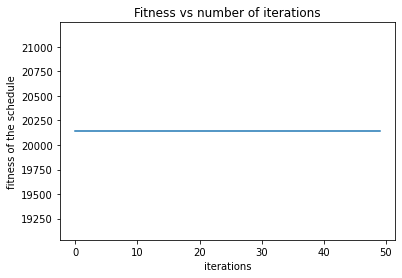

In [192]:
#Creating dataframe of fitness with number of iterations
iteration_fitness3=pd.DataFrame(plot_data_pso_june4,columns=['fitness'])

#Plotting the fitness against iterations
plt.plot(iteration_fitness3['fitness'])

plt.xlabel('iterations')
plt.ylabel('fitness of the schedule')

plt.title('Fitness vs number of iterations')

plt.show()

In [193]:
best_pso_june4.sort(reverse=True,key=myFunc1)

In [194]:
print_detectors(best_pso_june4)

The optimized locations of the detectors are:
By standing at location: (-33.935782, 151.14736) the detector catches 1420 vehicles between time 00:00:00-03:00:00
By standing at location: (-33.771925, 150.981914) the detector catches 1360 vehicles between time 19:00:00-23:00:00
By standing at location: (-33.764065, 151.082656) the detector catches 1208 vehicles between time 00:00:00-04:00:00
By standing at location: (-33.79042, 151.13532) the detector catches 1000 vehicles between time 16:00:00-19:45:00
By standing at location: (-33.853313, 150.850793) the detector catches 1000 vehicles between time 09:00:00-12:45:00
By standing at location: (-33.663932, 150.896417) the detector catches 960 vehicles between time 08:00:00-12:00:00
By standing at location: (-33.725157, 151.085146) the detector catches 833 vehicles between time 11:00:00-14:30:00
By standing at location: (-33.813802, 151.188075) the detector catches 820 vehicles between time 00:00:00-03:00:00
By standing at location: (-33.79

In [195]:
#Creating a list to store the detector's coordinates:
detector_coordinates_pso_june4=[]

print_offender_detector(detector_coordinates_pso_june4,best_pso_june4)

7 offenders are caught by standing at (-33.935782, 151.14736) between time 00:00:00-03:00:00
Offender 3 at time 01:53:41
Offender 4 at time 00:25:04
Offender 6 at time 00:24:28
Offender 9 at time 01:37:34
Offender 10 at time 00:46:37
Offender 16 at time 02:47:27
Offender 17 at time 02:50:47
4 offenders are caught by standing at (-33.771925, 150.981914) between time 19:00:00-23:00:00
Offender 44 at time 22:41:25
Offender 83 at time 19:49:27
Offender 91 at time 20:29:05
Offender 99 at time 22:53:59
5 offenders are caught by standing at (-33.764065, 151.082656) between time 00:00:00-04:00:00
Offender 5 at time 01:56:38
Offender 13 at time 03:18:55
Offender 15 at time 02:47:12
Offender 53 at time 00:40:33
Offender 60 at time 01:22:01
1 offenders are caught by standing at (-33.79042, 151.13532) between time 16:00:00-19:45:00
Offender 35 at time 18:36:22
1 offenders are caught by standing at (-33.853313, 150.850793) between time 09:00:00-12:45:00
Offender 76 at time 12:03:27
1 offenders are 

In [ ]:
off_vs_time(best_pso_june4)
det_vs_time(best_pso_june4)
det_vs_off(best_pso_june4,detector_coordinates_pso_june4)

In [197]:
#Map to plot the detectors and the offenders caught:
detector_offender_pso_june4=folium.Map(location=sydney,zoom_start=11)
detector_pso_june4=folium.Map(location=sydney,zoom_start=11)
detector_offender_pso_june4.add_child(folium.LatLngPopup())

In [198]:
plot_detector_offender(detector_offender_pso_june4,best_pso_june4,off_id,route_coordinates_with_time,offenders_coordinates,detector_coordinates_pso_june4)
plot_detector(detector_pso_june4,best_pso_june4,off_id,route_coordinates_with_time,offenders_coordinates,detector_coordinates_pso_june4)

In [199]:
detector_offender_pso_june4

In [200]:
detector_pso_june4

### For June 5:

In [201]:
#Creating initial population with 10 schedules printing the total working hours for each population
solutions=[]
for i in range(10):
    s=create_initialPopulation(detector_count,lat_long_roads,june_5)
    solutions.append(s)

Total time:78.0
Total time:80.0
Total time:79.75
Total time:80.0
Total time:78.75
Total time:78.75
Total time:78.25
Total time:79.5
Total time:78.75
Total time:79.25


In [202]:
solutions[:2]

[[[(-33.659342, 151.237223),
   [datetime.time(19, 0), datetime.time(21, 45)],
   636],
  [(-33.762664, 150.846458),
   [datetime.time(12, 0), datetime.time(14, 15)],
   540],
  [(-33.639743, 150.784387), [datetime.time(4, 0), datetime.time(4, 30)], 72],
  [(-33.776915, 150.856322), [datetime.time(3, 0), datetime.time(4, 30)], 189],
  [(-33.937123, 151.163032), [datetime.time(2, 0), datetime.time(4, 30)], 600],
  [(-33.661154, 151.188415),
   [datetime.time(19, 0), datetime.time(22, 15)],
   523],
  [(-33.93994, 150.734772), [datetime.time(18, 0), datetime.time(20, 0)], 480],
  [(-33.839571, 151.145664),
   [datetime.time(12, 0), datetime.time(14, 15)],
   540],
  [(-33.951897, 150.822075), [datetime.time(4, 0), datetime.time(7, 45)], 900],
  [(-33.946634, 150.87736), [datetime.time(2, 0), datetime.time(3, 15)], 89],
  [(-33.780329, 151.131923),
   [datetime.time(8, 0), datetime.time(11, 30)],
   840],
  [(-33.660294, 150.879659),
   [datetime.time(19, 0), datetime.time(21, 45)],
   66

In [203]:
#Initializing fitness
fitness=0

#To store the offender id caught by each detector, create a dictionary
off_id={}

In [204]:
schedule_with_fitness,off_id=combined_fit(solutions,off_id)

C:\Users\user\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [205]:
p_best_position,p_best_fitness,gbest_index,gbest_position,velocity_lat,velocity_long=initial_params(solutions,schedule_with_fitness)

In [206]:
best_pso_june5,plot_data_pso_june5,off_id=pso(solutions,50,alpha,june_5,velocity_lat,velocity_long,p_best_position,gbest_position,p_best_fitness,schedule_with_fitness,off_id)

ITERATION NUMBER: 1---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20252
ITERATION NUMBER: 2---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20252
ITERATION NUMBER: 3---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20252
ITERATION NUMBER: 4---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20252
ITERATION NUMBER: 5---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20252
ITERATION NUMBER: 6---------------------------------------------
Updating Velocity and position.................
Updatin

Updating p_best and g_best...........
Maximum fitness is 20792
ITERATION NUMBER: 48---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20792
ITERATION NUMBER: 49---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20792
ITERATION NUMBER: 50---------------------------------------------
Updating Velocity and position.................
Updating p_best and g_best...........
Maximum fitness is 20792


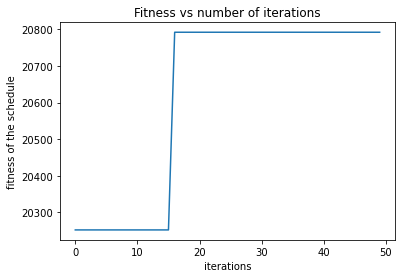

In [207]:
#Creating dataframe of fitness with number of iterations
iteration_fitness4=pd.DataFrame(plot_data_pso_june5,columns=['fitness'])

#Plotting the fitness against iterations
plt.plot(iteration_fitness4['fitness'])

plt.xlabel('iterations')
plt.ylabel('fitness of the schedule')

plt.title('Fitness vs number of iterations')

plt.show()

In [208]:
best_pso_june5.sort(reverse=True,key=myFunc1)

In [209]:
print_detectors(best_pso_june5)

The optimized locations of the detectors are:
By standing at location: (-33.93642, 151.127816) the detector catches 1420 vehicles between time 00:00:00-03:00:00
By standing at location: (-33.934738, 151.137512) the detector catches 1160 vehicles between time 16:00:00-20:00:00
By standing at location: (-33.763676, 151.08112) the detector catches 1160 vehicles between time 04:00:00-08:00:00
By standing at location: (-33.80177, 150.877297) the detector catches 1060 vehicles between time 09:00:00-13:00:00
By standing at location: (-33.714443, 151.006192) the detector catches 1000 vehicles between time 09:00:00-12:45:00
By standing at location: (-33.773977, 151.167586) the detector catches 960 vehicles between time 06:00:00-10:00:00
By standing at location: (-33.659154, 150.764864) the detector catches 960 vehicles between time 10:00:00-14:00:00
By standing at location: (-33.837676, 150.855952) the detector catches 940 vehicles between time 17:00:00-20:30:00
By standing at location: (-33.86

In [210]:
#Creating a list to store the detector's coordinates:
detector_coordinates_pso_june5=[]

print_offender_detector(detector_coordinates_pso_june5,best_pso_june5)

7 offenders are caught by standing at (-33.93642, 151.127816) between time 00:00:00-03:00:00
Offender 3 at time 01:53:41
Offender 4 at time 00:25:04
Offender 6 at time 00:24:28
Offender 9 at time 01:37:34
Offender 10 at time 00:46:37
Offender 16 at time 02:47:27
Offender 17 at time 02:50:47
2 offenders are caught by standing at (-33.934738, 151.137512) between time 16:00:00-20:00:00
Offender 31 at time 19:40:18
Offender 32 at time 18:13:31
2 offenders are caught by standing at (-33.763676, 151.08112) between time 04:00:00-08:00:00
Offender 21 at time 05:52:22
Offender 73 at time 07:34:25
1 offenders are caught by standing at (-33.80177, 150.877297) between time 09:00:00-13:00:00
Offender 75 at time 10:35:55
1 offenders are caught by standing at (-33.714443, 151.006192) between time 09:00:00-12:45:00
Offender 76 at time 12:03:27
1 offenders are caught by standing at (-33.837676, 150.855952) between time 17:00:00-20:30:00
Offender 31 at time 19:40:18
2 offenders are caught by standing at

In [ ]:
off_vs_time(best_pso_june5)
det_vs_time(best_pso_june5)
det_vs_off(best_pso_june5,detector_coordinates_pso_june5)

In [211]:
#Map to plot the detectors and the offenders caught:
detector_offender_pso_june5=folium.Map(location=sydney,zoom_start=11)
detector_pso_june5=folium.Map(location=sydney,zoom_start=11)
detector_offender_pso_june5.add_child(folium.LatLngPopup())

In [212]:
plot_detector_offender(detector_offender_pso_june5,best_pso_june5,off_id,route_coordinates_with_time,offenders_coordinates,detector_coordinates_pso_june5)
plot_detector(detector_pso_june5,best_pso_june5,off_id,route_coordinates_with_time,offenders_coordinates,detector_coordinates_pso_june5)

In [213]:
detector_offender_pso_june5

In [214]:
detector_pso_june5